# Predictive Modeling of Credit Risk in the Context of Loan Applications

## Authors 

- Arthur DANJOU
- Axelle MERIC
- Moritz VON SIEMES

## Imports

In [46]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency

import shap
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split,
)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [47]:
def cramers_V(var1: pd.Series, var2: pd.Series) -> float:
    """Calculate Cramér's V statistic for categorical-categorical association.

    Args:
        var1 (pd.Series): First categorical variable.
        var2 (pd.Series): Second categorical variable.

    Returns:
        float: Cramér's V statistic.

    """
    crosstab = np.array(pd.crosstab(var1, var2))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1
    return stat / (obs * mini)

# 1 Introduction

## 1.1 Dataset presentation

### Dataset import

In [48]:
data = pd.read_csv(os.path.join(os.getcwd(), "data", "Loan_data.csv"))
data = data.drop(columns=["ApplicationDate", "LoanApproved"], axis=1)
data.shape

(20000, 34)

### Dataset exploration

In [49]:
data.head()

Age  AnnualIncome  CreditScore EmploymentStatus EducationLevel  Experience  \
0   45         39948          617         Employed         Master          22   
1   38         39709          628         Employed      Associate          15   
2   47         40724          570         Employed       Bachelor          26   
3   58         69084          545         Employed    High School          34   
4   37        103264          594         Employed      Associate          17   

   LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  ...  \
0       13152            48       Married                   2  ...   
1       26045            48        Single                   1  ...   
2       17627            36       Married                   2  ...   
3       37898            96        Single                   1  ...   
4        9184            36       Married                   1  ...   

  TotalLiabilities  MonthlyIncome  UtilityBillsPaymentHistory  JobTenure  \
0            19183    3329.000000                    0.724972         11   
1             9595    3309.083333                    0.935132          3   
2           128874    3393.666667                    0.872241          6   
3             5370    5757.000000                    0.896155          5   
4            17286    8605.333333                    0.941369          5   

   NetWorth  BaseInterestRate  InterestRate MonthlyLoanPayment  \
0    126928          0.199652      0.227590         419.805992   
1     43609          0.207045      0.201077         794.054238   
2      5205          0.217627      0.212548         666.406688   
3     99452          0.300398      0.300911        1047.506980   
4    227019          0.197184      0.175990         330.179140   

   TotalDebtToIncomeRatio  RiskScore  
0                0.181077       49.0  
1                0.389852       52.0  
2                0.462157       52.0  
3                0.313098       54.0  
4                0.070210       36.0  

[5 rows x 34 columns]

In [50]:
data.tail()

Age  AnnualIncome  CreditScore EmploymentStatus EducationLevel  \
19995   44         30180          587         Employed    High School   
19996   56         49246          567         Employed      Associate   
19997   44         48958          645         Employed       Bachelor   
19998   60         41025          560         Employed    High School   
19999   20         53227          574         Employed      Associate   

       Experience  LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  \
19995          19       24521            36       Married                   3   
19996          33       25818            36       Married                   5   
19997          20       37033            72       Married                   3   
19998          36       14760            72       Married                   3   
19999           0       32055            48       Married                   0   

       ... TotalLiabilities  MonthlyIncome  UtilityBillsPaymentHistory  \
19995  ...            25642    2515.000000                    0.826217   
19996  ...             5569    4103.833333                    0.816618   
19997  ...             4653    4079.833333                    0.887216   
19998  ...            11485    3418.750000                    0.843787   
19999  ...            41636    4435.583333                    0.853801   

       JobTenure  NetWorth  BaseInterestRate  InterestRate MonthlyLoanPayment  \
19995          1     55327          0.216021      0.195574         905.767712   
19996          3     64002          0.227318      0.199168         958.395633   
19997          3    103663          0.229533      0.226766         945.427454   
19998          5     10600          0.249760      0.264873         411.168284   
19999          5     41372          0.240055      0.242693        1049.830407   

       TotalDebtToIncomeRatio  RiskScore  
19995                0.627741       55.0  
19996                0.334418       54.0  
19997                0.357227       45.0  
19998                0.408678       59.0  
19999                0.298006       59.0  

[5 rows x 34 columns]

In [51]:
data.describe(include="all")

Age   AnnualIncome   CreditScore EmploymentStatus  \
count   20000.000000   20000.000000  20000.000000            20000   
unique           NaN            NaN           NaN                3   
top              NaN            NaN           NaN         Employed   
freq             NaN            NaN           NaN            17036   
mean       39.752600   59161.473550    571.612400              NaN   
std        11.622713   40350.845168     50.997358              NaN   
min        18.000000   15000.000000    343.000000              NaN   
25%        32.000000   31679.000000    540.000000              NaN   
50%        40.000000   48566.000000    578.000000              NaN   
75%        48.000000   74391.000000    609.000000              NaN   
max        80.000000  485341.000000    712.000000              NaN   

       EducationLevel    Experience     LoanAmount  LoanDuration  \
count           20000  20000.000000   20000.000000  20000.000000   
unique              5           NaN            NaN           NaN   
top          Bachelor           NaN            NaN           NaN   
freq             6054           NaN            NaN           NaN   
mean              NaN     17.522750   24882.867800     54.057000   
std               NaN     11.316836   13427.421217     24.664857   
min               NaN      0.000000    3674.000000     12.000000   
25%               NaN      9.000000   15575.000000     36.000000   
50%               NaN     17.000000   21914.500000     48.000000   
75%               NaN     25.000000   30835.000000     72.000000   
max               NaN     61.000000  184732.000000    120.000000   

       MaritalStatus  NumberOfDependents  ... TotalLiabilities  MonthlyIncome  \
count          20000        20000.000000  ...     2.000000e+04   20000.000000   
unique             4                 NaN  ...              NaN            NaN   
top          Married                 NaN  ...              NaN            NaN   
freq           10041                 NaN  ...              NaN            NaN   
mean             NaN            1.517300  ...     3.625241e+04    4891.715521   
std              NaN            1.386325  ...     4.725151e+04    3296.771598   
min              NaN            0.000000  ...     3.720000e+02    1250.000000   
25%              NaN            0.000000  ...     1.119675e+04    2629.583333   
50%              NaN            1.000000  ...     2.220300e+04    4034.750000   
75%              NaN            2.000000  ...     4.314650e+04    6163.000000   
max              NaN            5.000000  ...     1.417302e+06   25000.000000   

        UtilityBillsPaymentHistory     JobTenure      NetWorth  \
count                 20000.000000  20000.000000  2.000000e+04   
unique                         NaN           NaN           NaN   
top                            NaN           NaN           NaN   
freq                           NaN           NaN           NaN   
mean                      0.799918      5.002650  7.229432e+04   
std                       0.120665      2.236804  1.179200e+05   
min                       0.259203      0.000000  1.000000e+03   
25%                       0.727379      3.000000  8.734750e+03   
50%                       0.820962      5.000000  3.285550e+04   
75%                       0.892333      6.000000  8.882550e+04   
max                       0.999433     16.000000  2.603208e+06   

        BaseInterestRate  InterestRate MonthlyLoanPayment  \
count       20000.000000  20000.000000       20000.000000   
unique               NaN           NaN                NaN   
top                  NaN           NaN                NaN   
freq                 NaN           NaN                NaN   
mean            0.239124      0.239110         911.607052   
std             0.035509      0.042205         674.583473   
min             0.130101      0.113310          97.030193   
25%             0.213889      0.209142         493.763700   
50%             0.236157      0.235390      

In [52]:
data.columns

Index(['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus',
       'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration',
       'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus',
       'MonthlyDebtPayments', 'CreditCardUtilizationRate',
       'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
       'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate',
       'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore'],
      dtype='object')

In [53]:
data.dtypes

Age                             int64
AnnualIncome                    int64
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                    int64
MaritalStatus                  object
NumberOfDependents              int64
HomeOwnershipStatus            object
MonthlyDebtPayments             int64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines         int64
NumberOfCreditInquiries         int64
DebtToIncomeRatio             float64
BankruptcyHistory               int64
LoanPurpose                    object
PreviousLoanDefaults            int64
PaymentHistory                  int64
LengthOfCreditHistory           int64
SavingsAccountBalance           int64
CheckingAccountBalance          int64
TotalAssets                     int64
TotalLiabilities                int64
MonthlyIncome                 float64
UtilityBills

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         20000 non-null  int64  
 1   AnnualIncome                20000 non-null  int64  
 2   CreditScore                 20000 non-null  int64  
 3   EmploymentStatus            20000 non-null  object 
 4   EducationLevel              20000 non-null  object 
 5   Experience                  20000 non-null  int64  
 6   LoanAmount                  20000 non-null  int64  
 7   LoanDuration                20000 non-null  int64  
 8   MaritalStatus               20000 non-null  object 
 9   NumberOfDependents          20000 non-null  int64  
 10  HomeOwnershipStatus         20000 non-null  object 
 11  MonthlyDebtPayments         20000 non-null  int64  
 12  CreditCardUtilizationRate   20000 non-null  float64
 13  NumberOfOpenCreditLines     200

## 1.2 Features Analysis

In [55]:
CATEGORIAL_LIMIT = 2


def create_feature_arrays(data: pd.DataFrame) -> tuple[list[str], list[str]]:
    """Split the DataFrame columns into numerical and categorical feature lists.

    Args:
        data (pd.DataFrame): The DataFrame to analyze.

    Returns:
        tuple[list[str], list[str]]: Two lists containing the names of the numerical and categorical features.

    """
    numerical_features = []
    categorical_features = []
    for col in data.columns:
        if str(data[col].dtypes) in ["int32", "int64", "float64"]:
            if len(data[col].unique()) == CATEGORIAL_LIMIT:
                categorical_features.append(col)
            else:
                numerical_features.append(col)
        else:
            categorical_features.append(col)
    return numerical_features, categorical_features

In [56]:
numerical_features, categorical_features = create_feature_arrays(data)

print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(
    f"Categorical Features ({len(categorical_features)}): {categorical_features}",
)

Numerical Features (27): ['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore']
Categorical Features (7): ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults']


### 1.2.1 Target variable

In [57]:
TARGET_VARIABLE = "RiskScore"
RANDOM_SEED = 2306

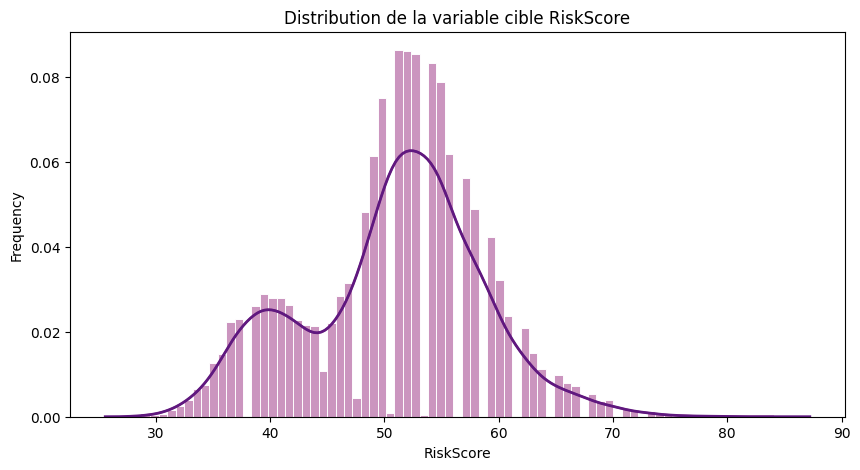

In [58]:
colors = sns.color_palette("magma", 6)

plt.figure(figsize=(10, 5))
sns.histplot(
    data[TARGET_VARIABLE],
    kde=True,
    color=colors[2],
    edgecolor="white",
    stat="density",
)
sns.kdeplot(data[TARGET_VARIABLE], color=colors[1], linewidth=2)

plt.xlabel(TARGET_VARIABLE)
plt.ylabel("Frequency")
plt.title(f"Distribution de la variable cible {TARGET_VARIABLE}")
plt.show()

In [59]:
data[TARGET_VARIABLE].describe()

count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
Name: RiskScore, dtype: float64

#### Split Train/Test

In [60]:
X = data.drop(columns=[TARGET_VARIABLE], axis=1)
y = data[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

In [61]:
train_df = X_train.copy()
train_df[TARGET_VARIABLE] = (
    y_train  # Add target variable to training set for exploration with seaborn
)

### 1.2.2 Analysis of the target’s density against modalities of categorical feature

<Figure size 1000x600 with 0 Axes>

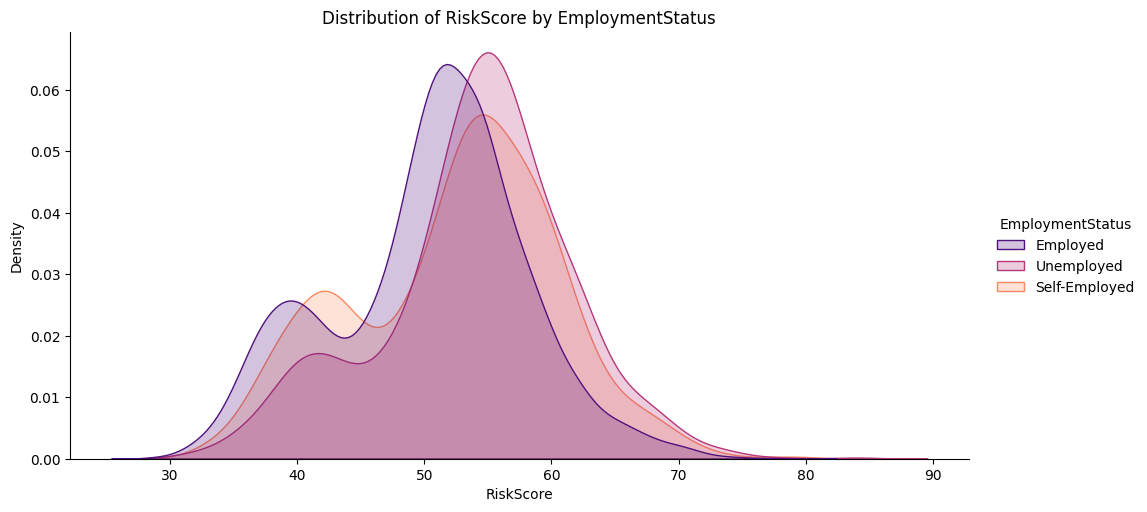

<Figure size 1000x600 with 0 Axes>

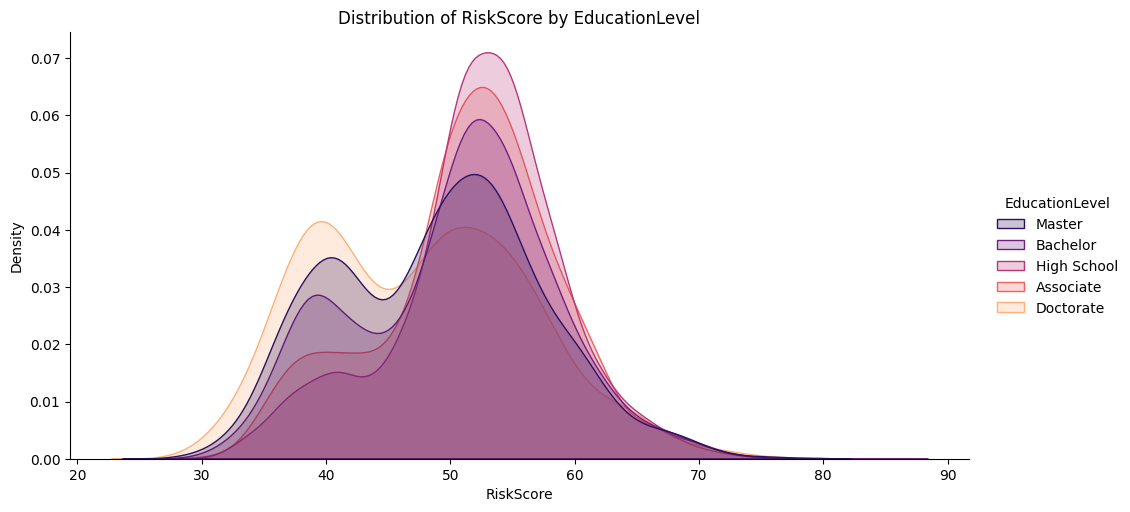

<Figure size 1000x600 with 0 Axes>

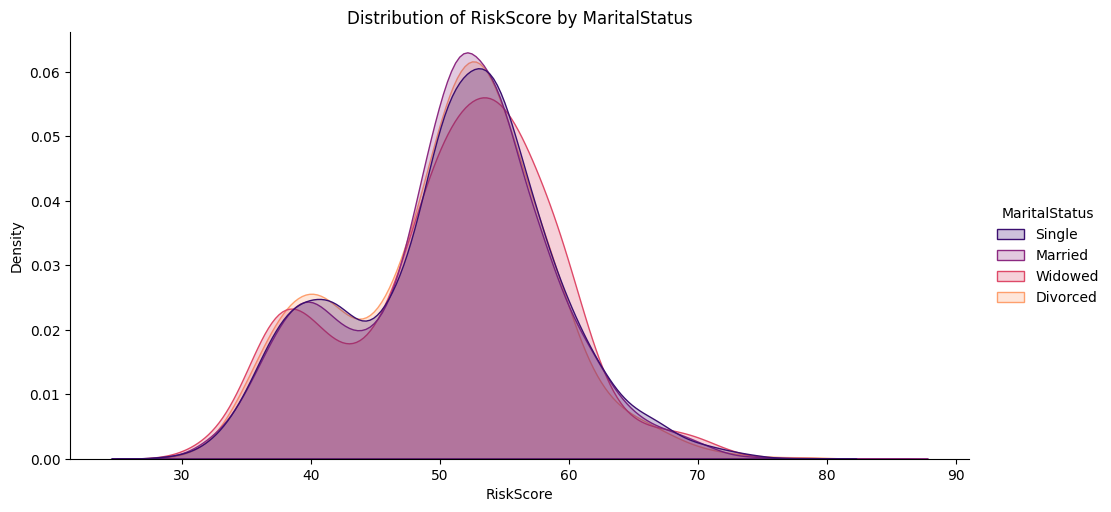

<Figure size 1000x600 with 0 Axes>

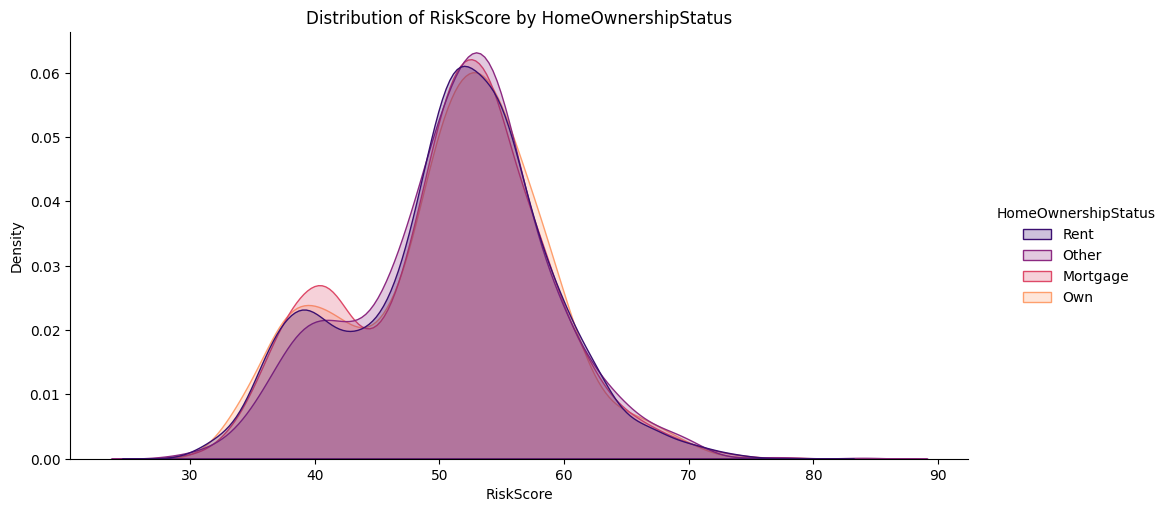

<Figure size 1000x600 with 0 Axes>

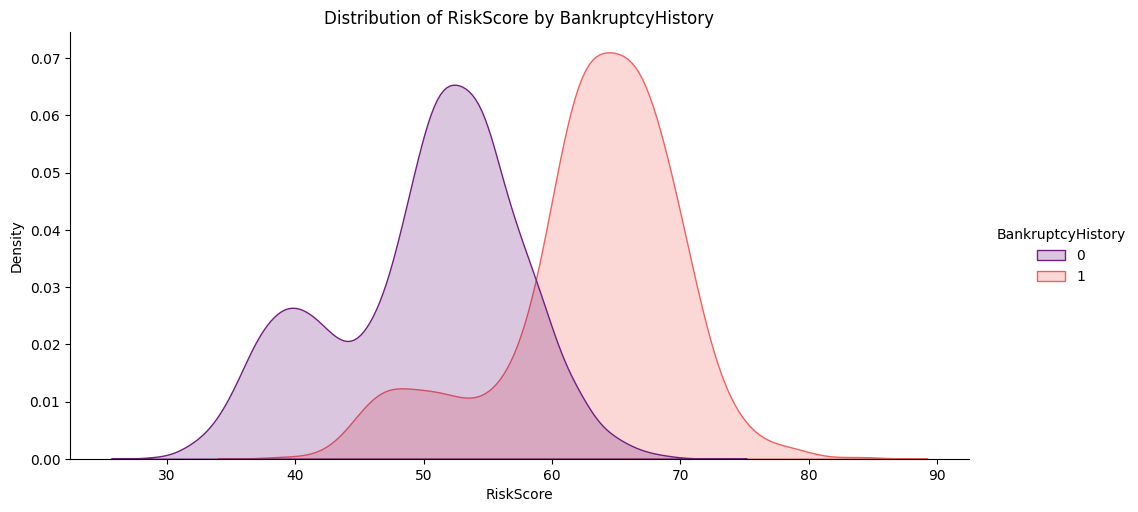

<Figure size 1000x600 with 0 Axes>

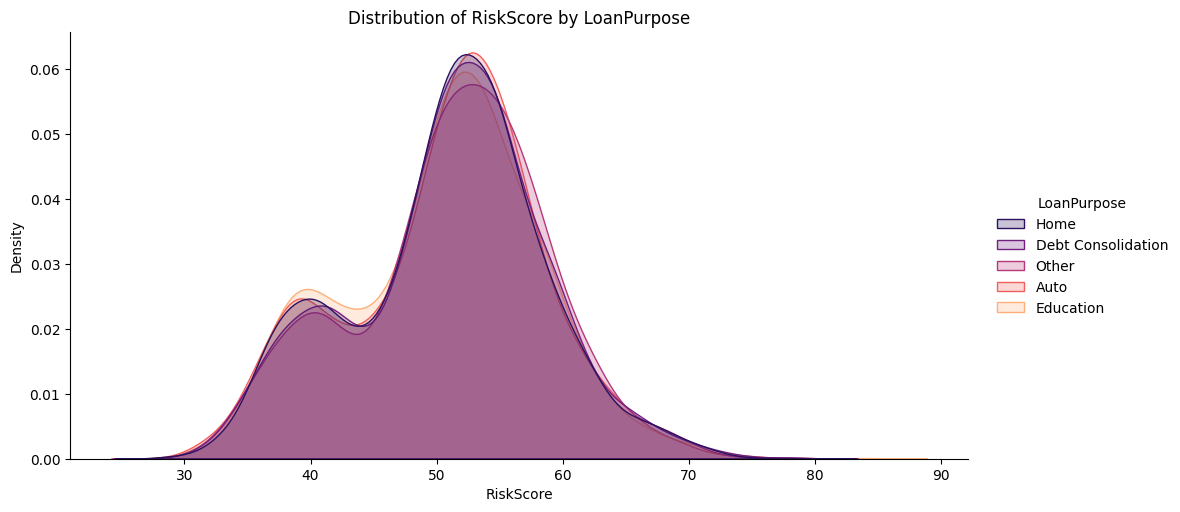

<Figure size 1000x600 with 0 Axes>

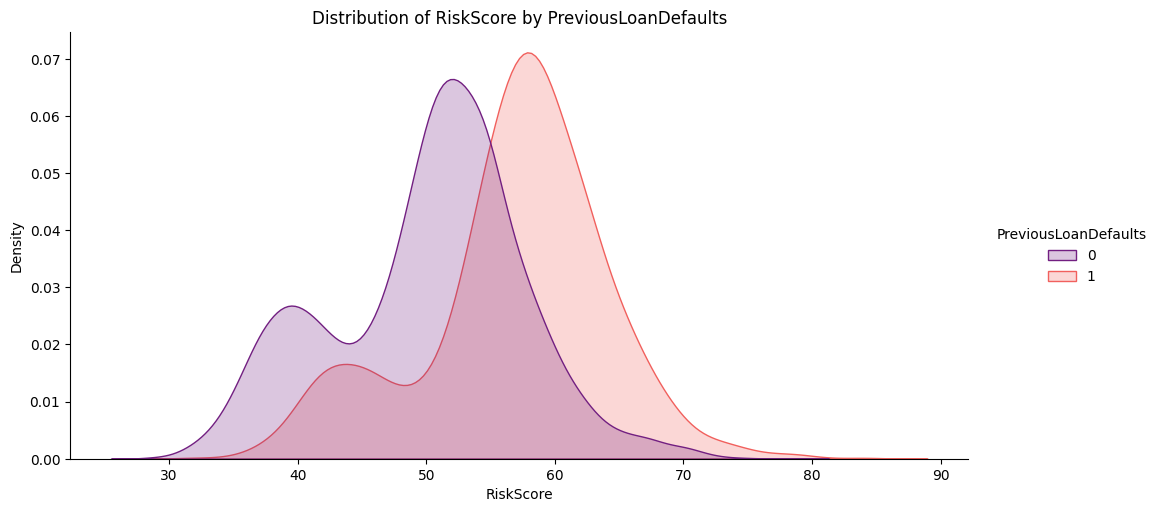

In [62]:
for col in categorical_features:
    colors = sns.color_palette("magma", len(train_df[col].unique()))
    plt.figure(figsize=(10, 6))
    sns.displot(
        data=train_df,
        x=TARGET_VARIABLE,
        hue=col,
        kind="kde",
        fill=True,
        common_norm=False,
        palette=colors,
        aspect=2,
    )
    plt.title(f"Distribution of {TARGET_VARIABLE} by {col}")
    plt.xlabel(TARGET_VARIABLE)
    plt.ylabel("Density")
    plt.show()

### 1.2.3 Correlation between features

#### Correlation between continuous features. 

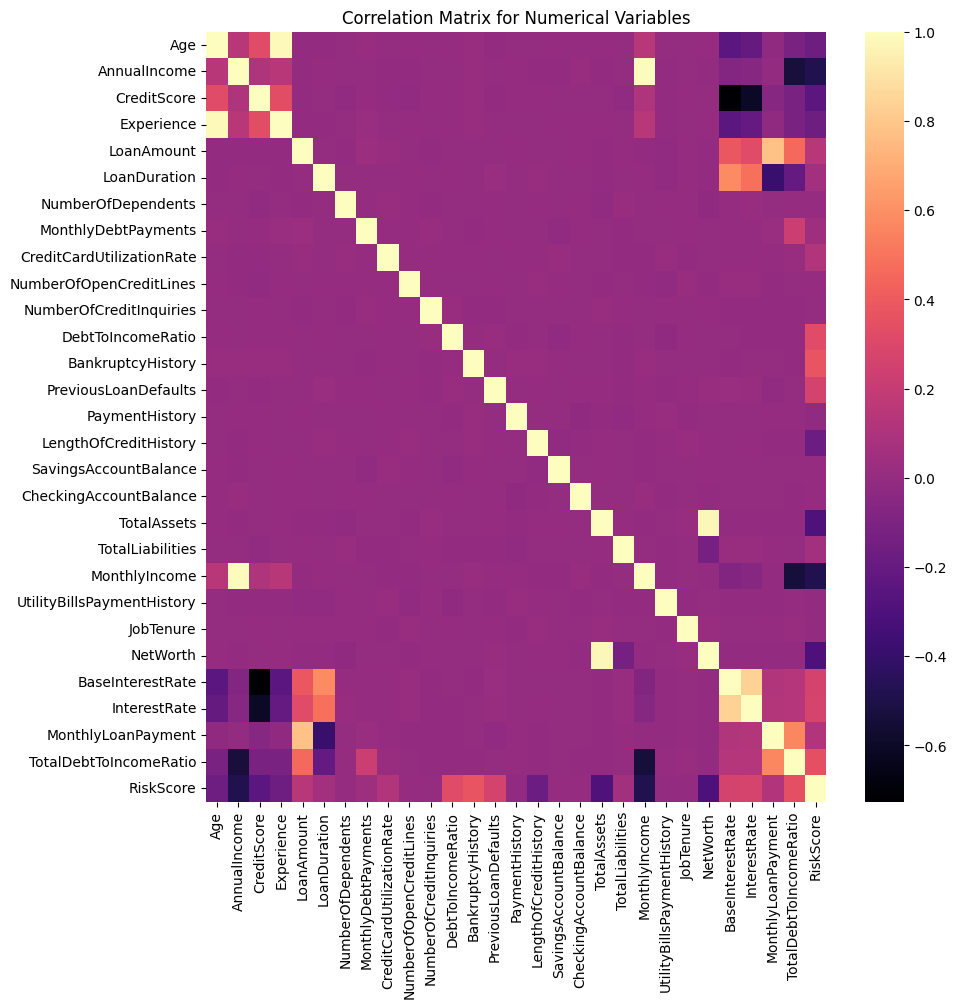

In [63]:
correlation_matrix = train_df.corr(numeric_only=True, method="pearson")
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap=sns.color_palette("magma", as_cmap=True))
plt.title("Correlation Matrix for Numerical Variables")
plt.show()

In [64]:
CORRELATION_THRESHOLD = 0.7
nb_variables = correlation_matrix.shape[0]
for i in range(nb_variables):
    for j in range(i + 1, nb_variables):
        if abs(correlation_matrix.iloc[i, j]) > CORRELATION_THRESHOLD:
            print(
                f"{correlation_matrix.index.to_numpy()[i]} and {correlation_matrix.columns[j]} are too dependent, corr = {correlation_matrix.iloc[i, j]}",
            )

Age and Experience are too dependent, corr = 0.9828247788130151
AnnualIncome and MonthlyIncome are too dependent, corr = 0.9896003823227325
CreditScore and BaseInterestRate are too dependent, corr = -0.7258646189841266
LoanAmount and MonthlyLoanPayment are too dependent, corr = 0.7800373257678835
TotalAssets and NetWorth are too dependent, corr = 0.9785984523471244
BaseInterestRate and InterestRate are too dependent, corr = 0.8337415604506


#### Correlation between categorical features.

In [65]:
rows = []

for var1 in categorical_features:
    col = []
    for var2 in categorical_features:
        cramers = cramers_V(X_train[var1], X_train[var2])
        col.append(round(cramers, 2))
    rows.append(col)

cramers_results = np.array(rows)
v_cramer_resultats = pd.DataFrame(
    cramers_results,
    columns=categorical_features,
    index=categorical_features,
)

v_cramer_resultats

EmploymentStatus  EducationLevel  MaritalStatus  \
EmploymentStatus                  1.00            0.01            0.0   
EducationLevel                    0.01            1.00            0.0   
MaritalStatus                     0.00            0.00            1.0   
HomeOwnershipStatus               0.00            0.00            0.0   
BankruptcyHistory                 0.00            0.00            0.0   
LoanPurpose                       0.00            0.00            0.0   
PreviousLoanDefaults              0.00            0.00            0.0   

                      HomeOwnershipStatus  BankruptcyHistory  LoanPurpose  \
EmploymentStatus                      0.0                0.0          0.0   
EducationLevel                        0.0                0.0          0.0   
MaritalStatus                         0.0                0.0          0.0   
HomeOwnershipStatus                   1.0                0.0          0.0   
BankruptcyHistory                     0.0                1.0          0.0   
LoanPurpose                           0.0                0.0          1.0   
PreviousLoanDefaults                  0.0                0.0          0.0   

                      PreviousLoanDefaults  
EmploymentStatus                       0.0  
EducationLevel                         0.0  
MaritalStatus                          0.0  
HomeOwnershipStatus                    0.0  
BankruptcyHistory                      0.0  
LoanPurpose                            0.0  
PreviousLoanDefaults                   1.0

In [66]:
CORRELATION_THRESHOLD = 0.5

for i in range(v_cramer_resultats.shape[0]):
    for j in range(i + 1, v_cramer_resultats.shape[0]):
        if v_cramer_resultats.iloc[i, j] > CORRELATION_THRESHOLD:
            print(
                f"The variables {v_cramer_resultats.index[i]} and {v_cramer_resultats.columns[j]} are strongly correlated (Cramér's V = {v_cramer_resultats.iloc[i, j]})",
            )

### 1.2.4 Analysis of the feature–target scatter plots

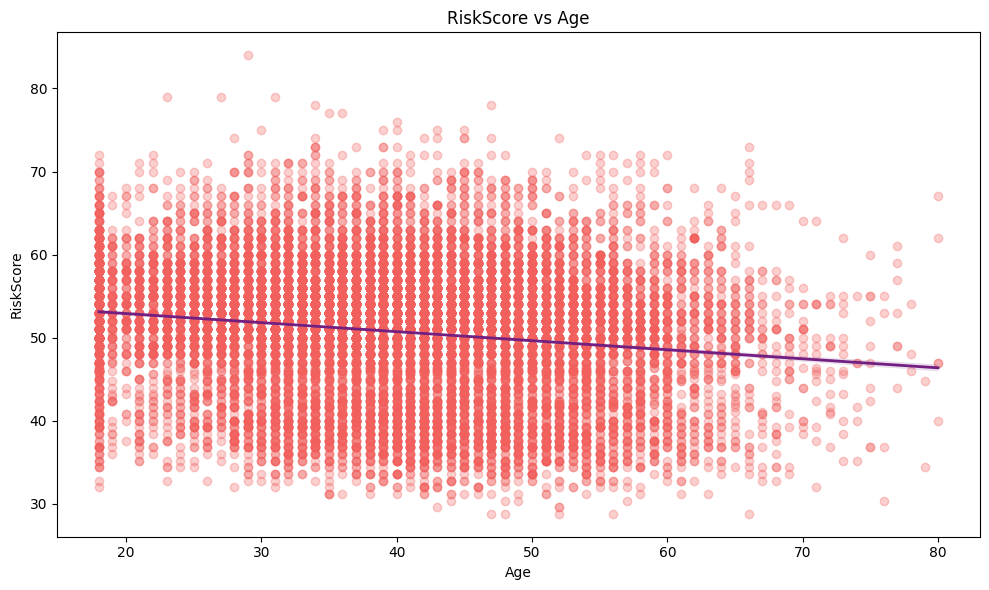

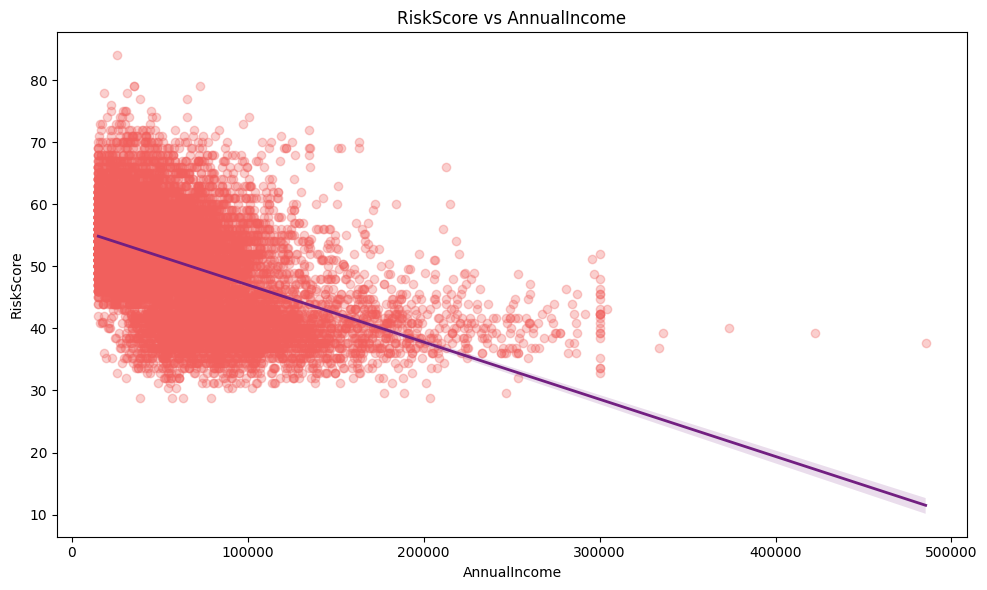

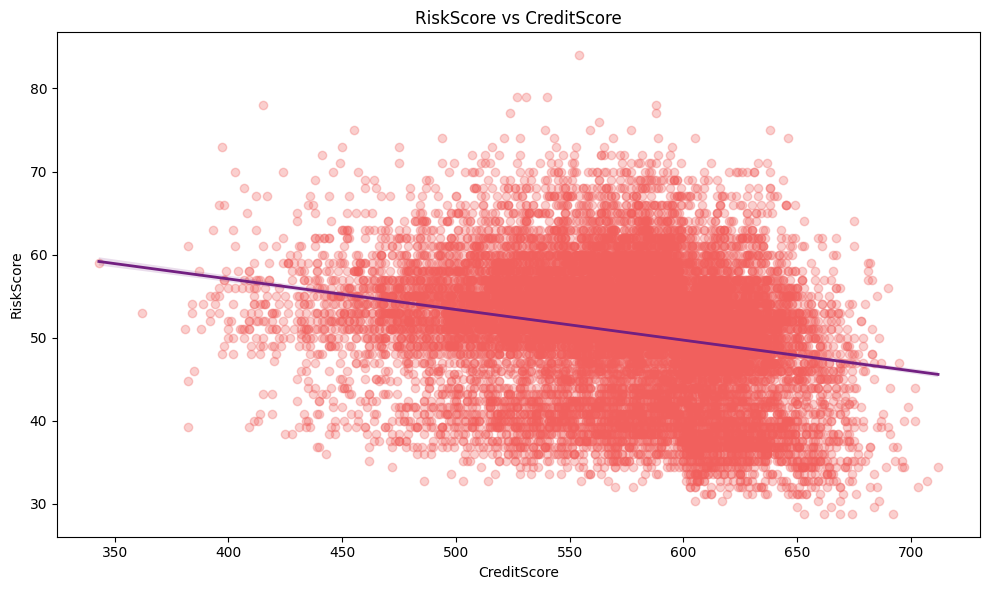

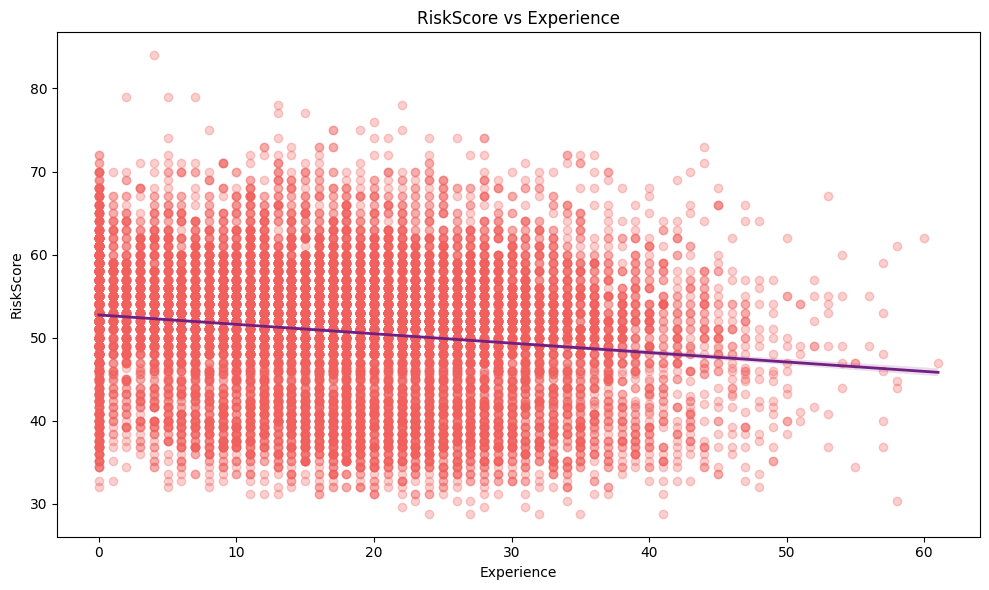

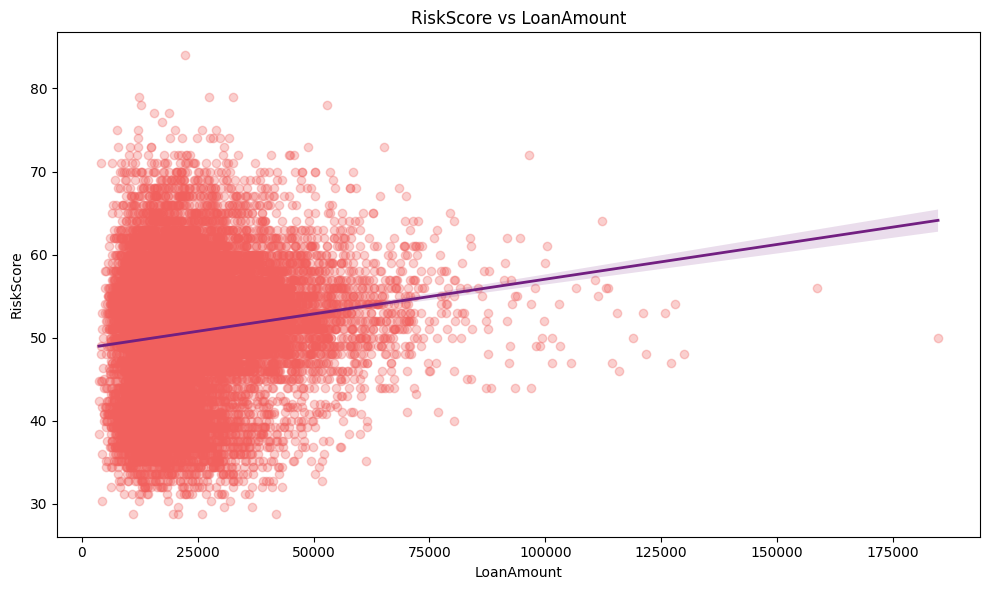

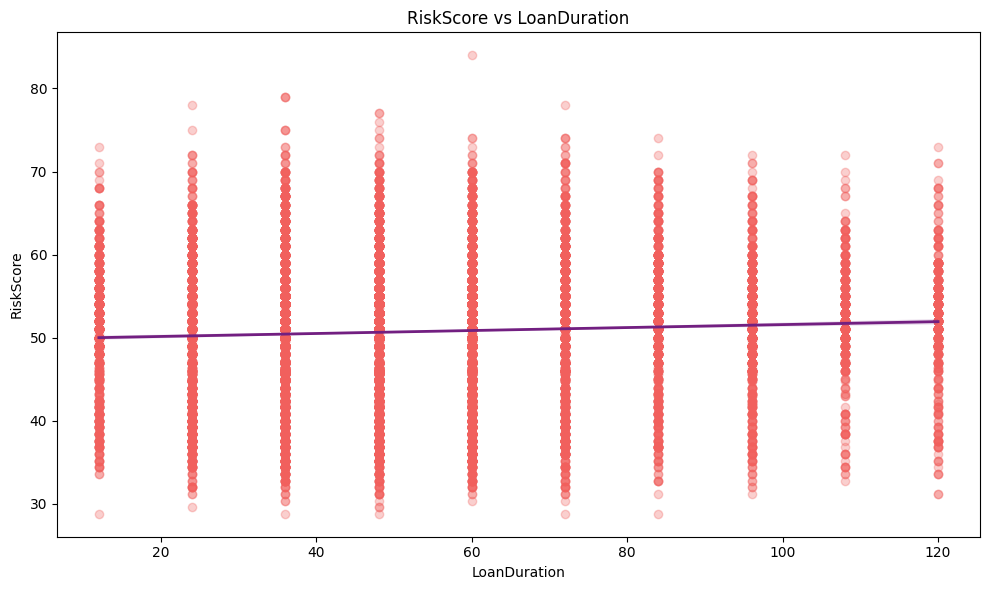

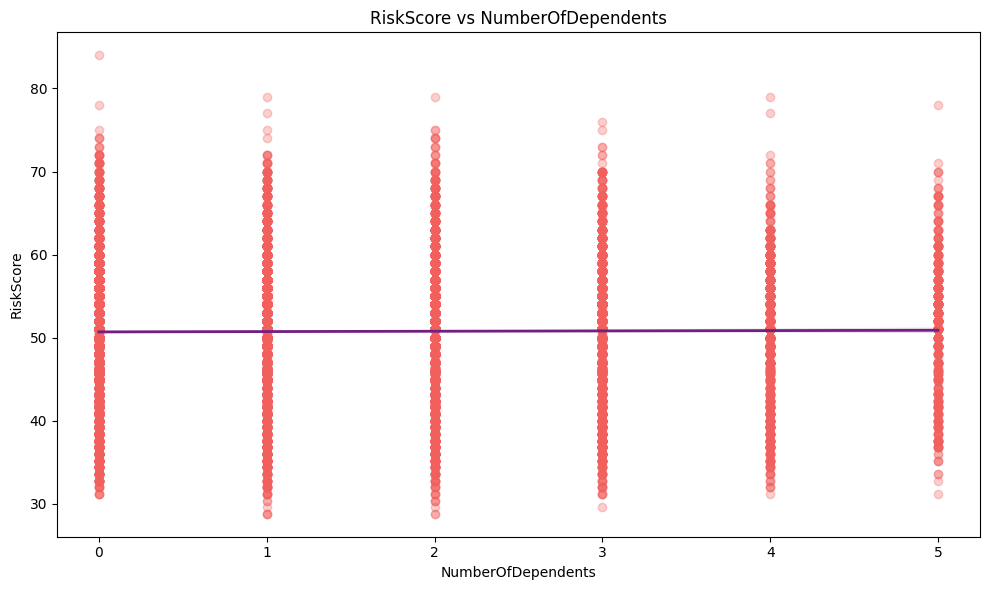

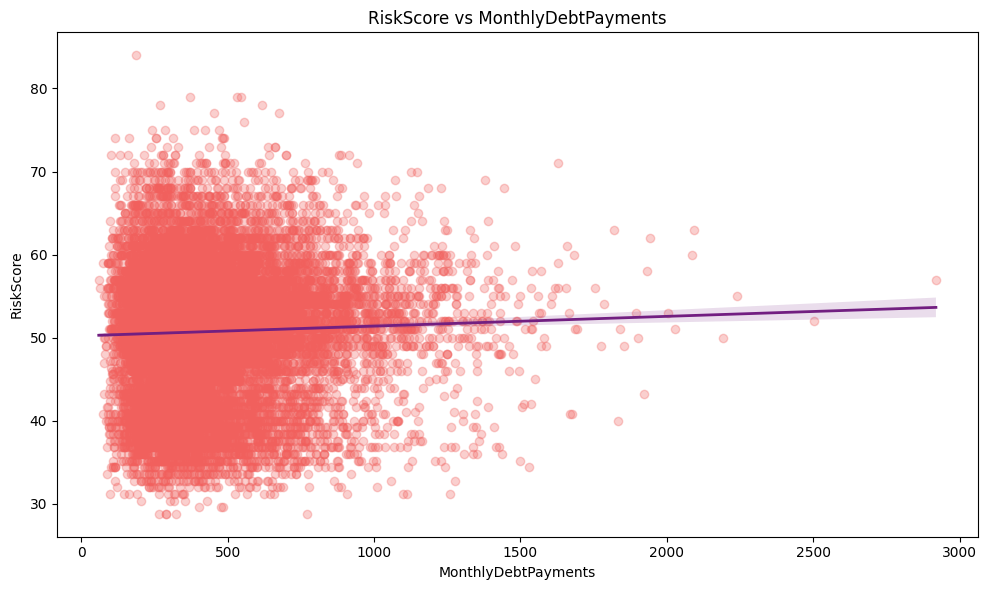

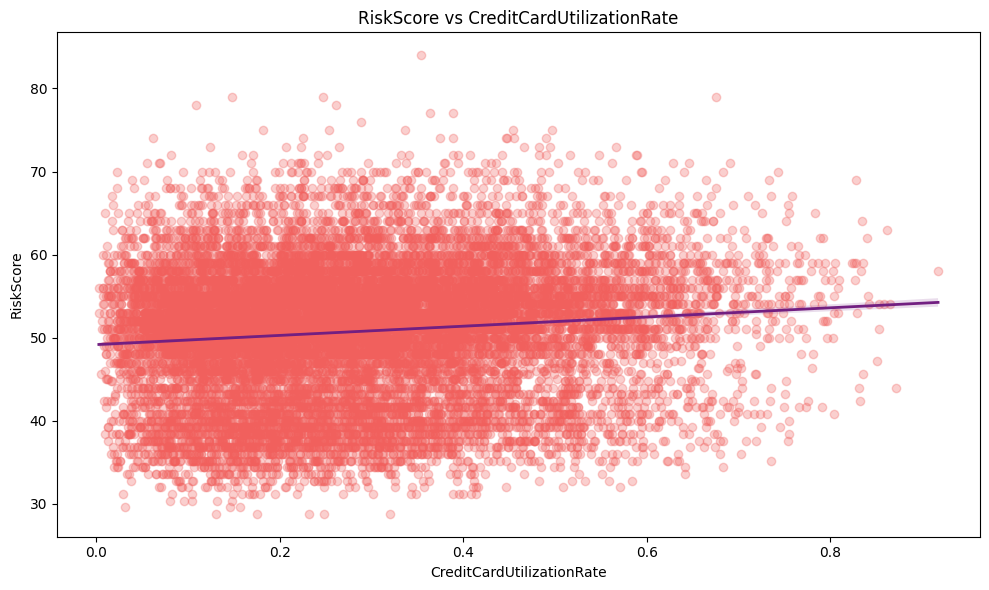

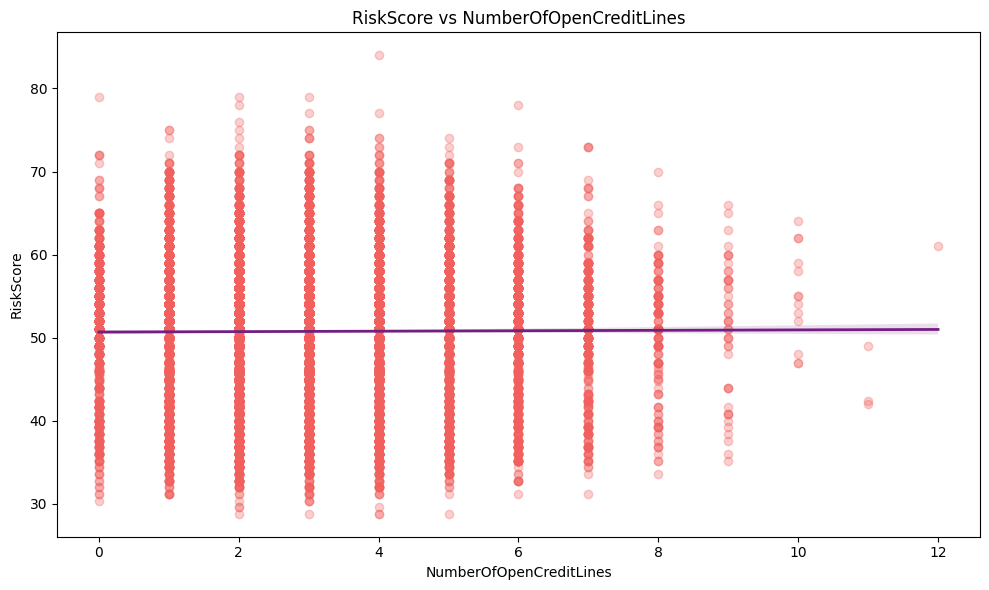

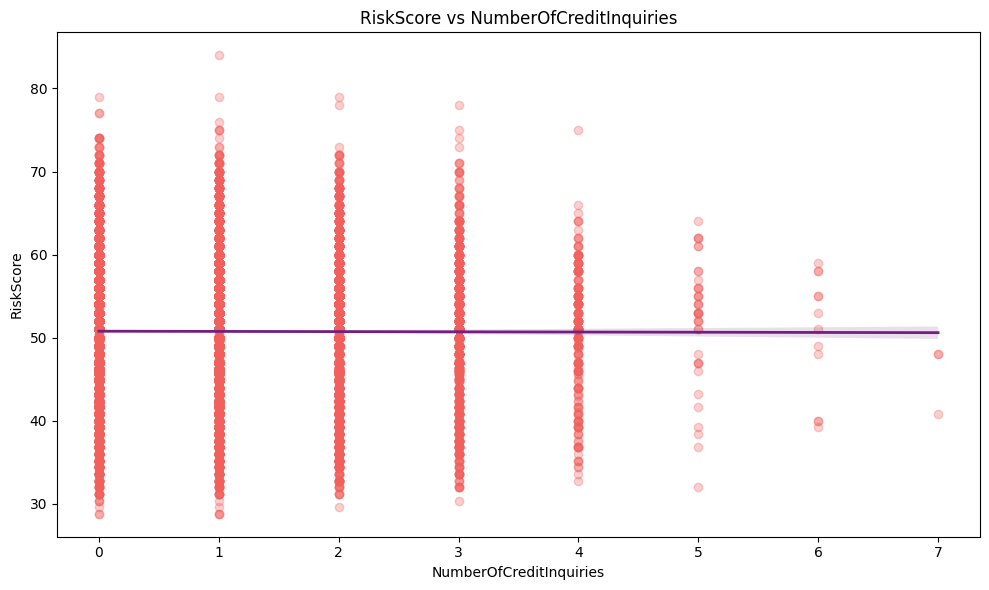

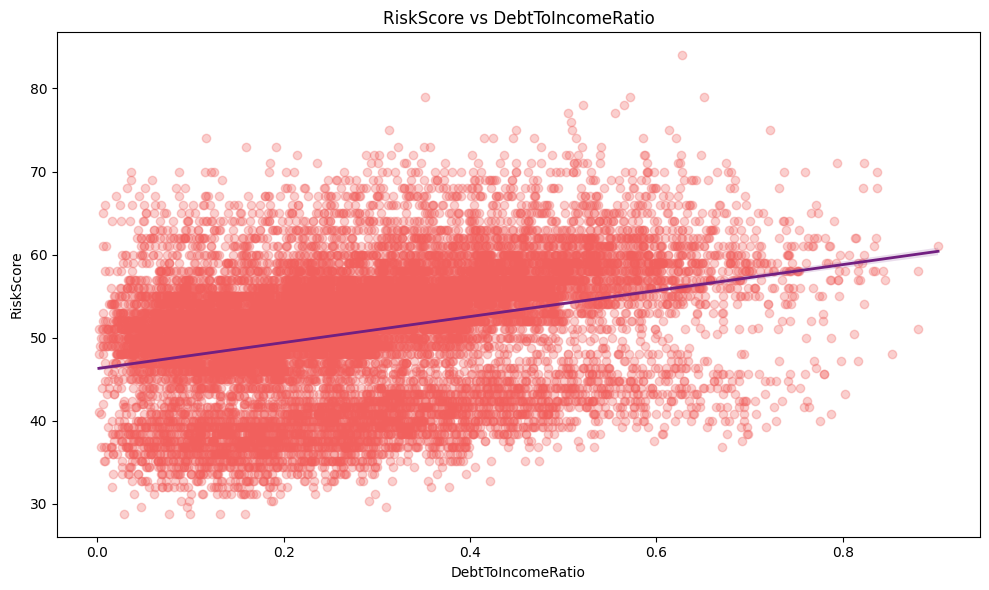

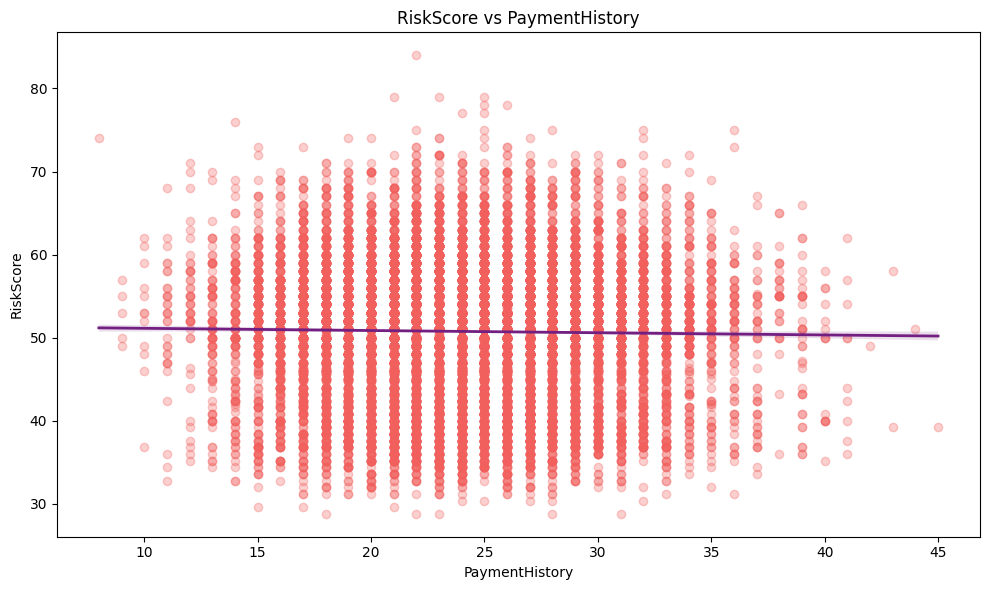

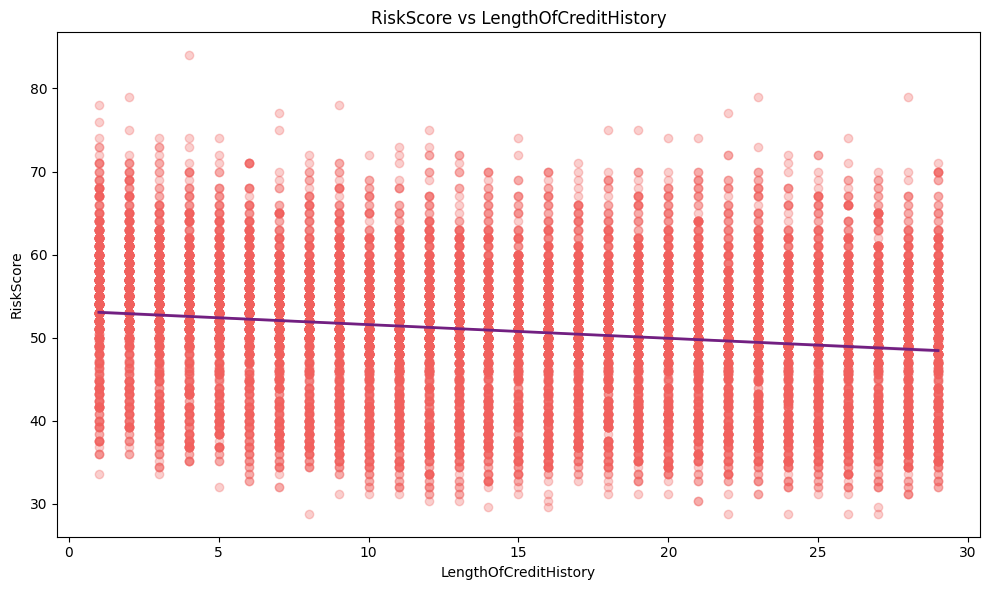

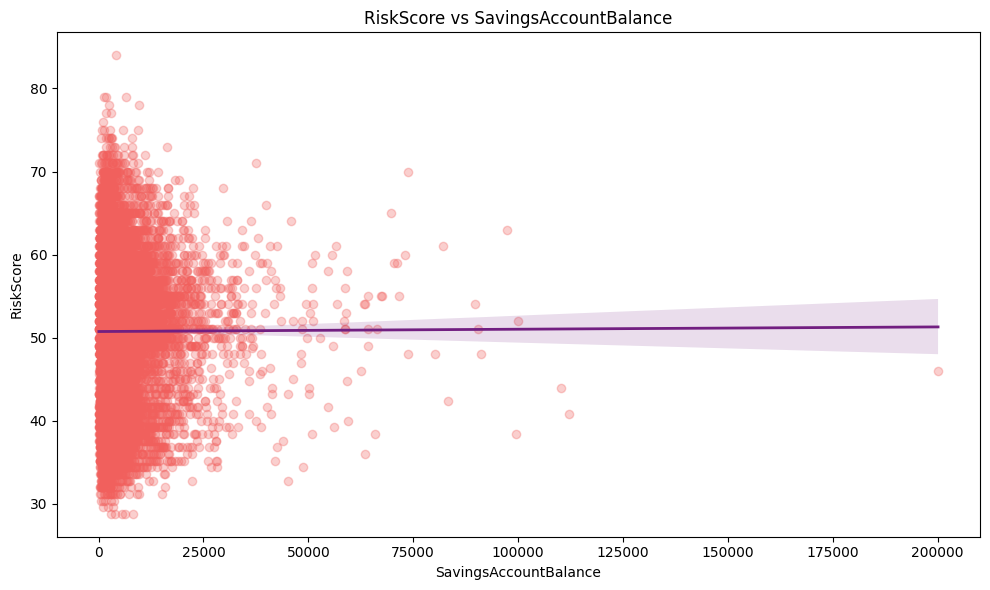

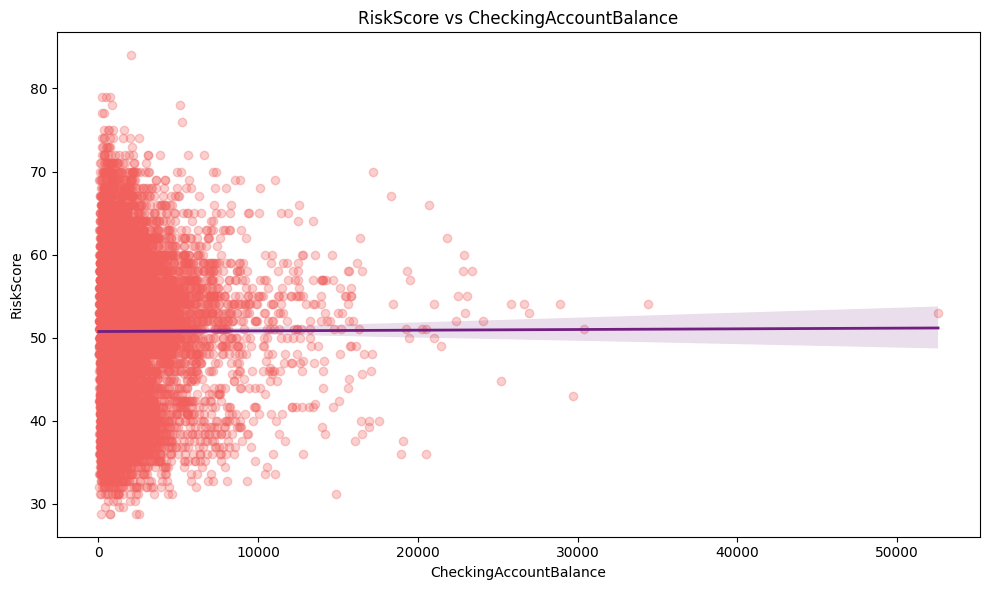

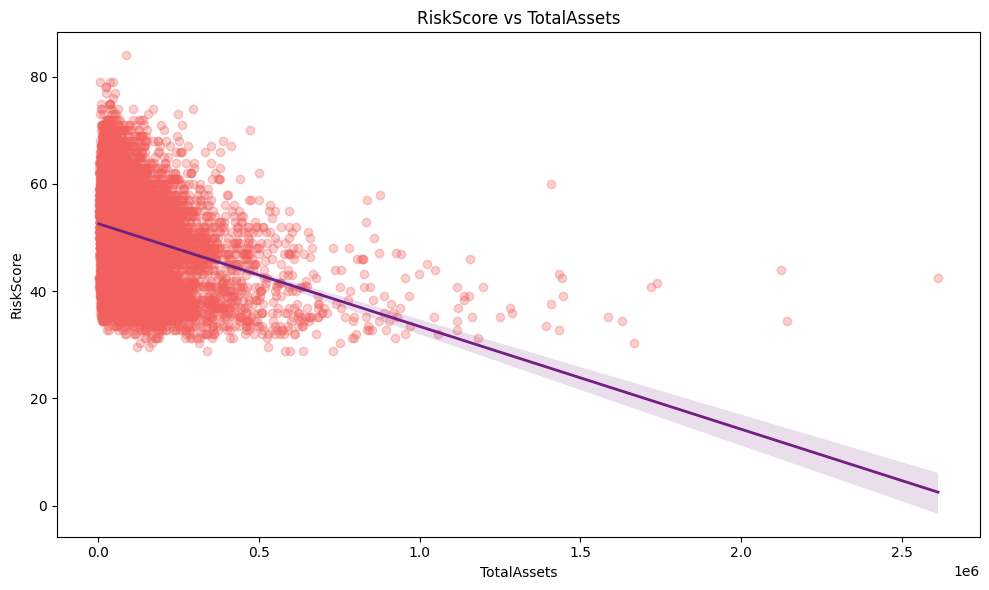

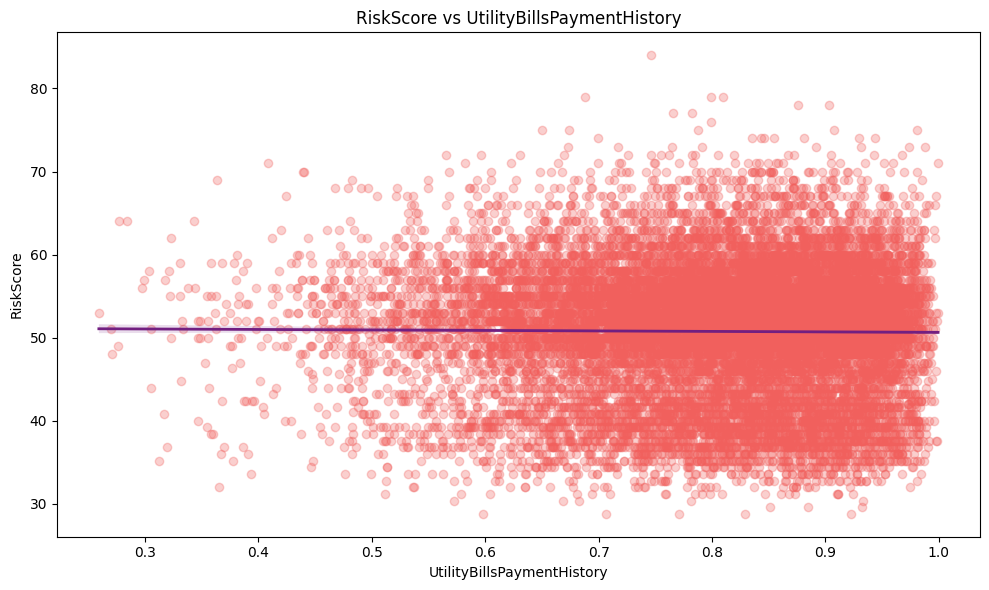

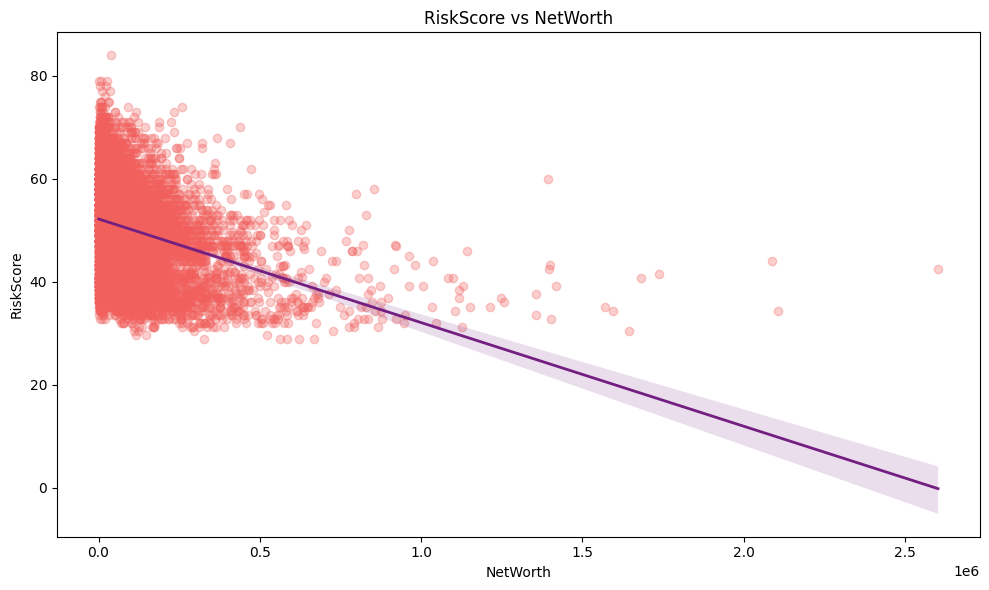

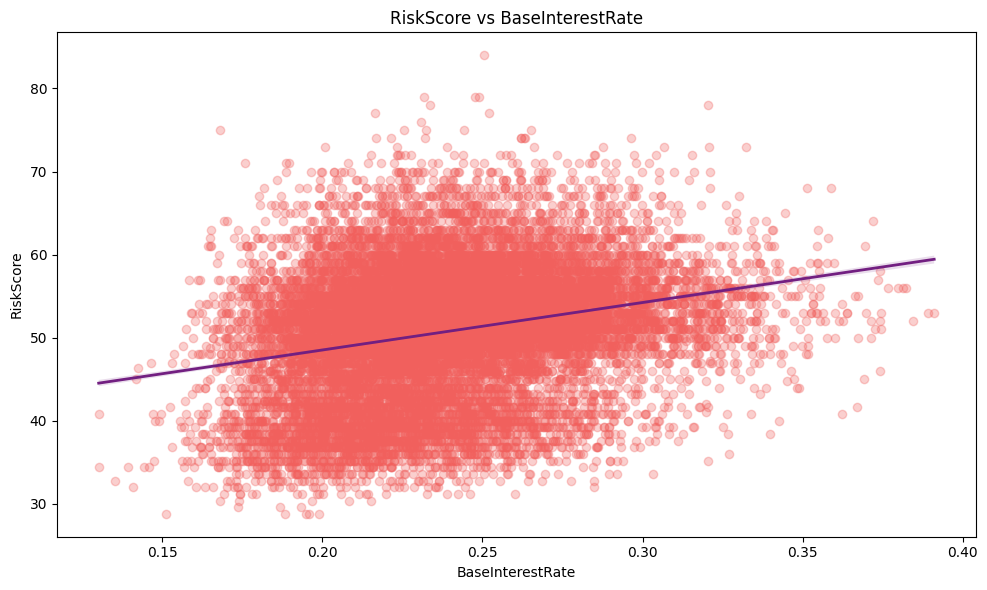

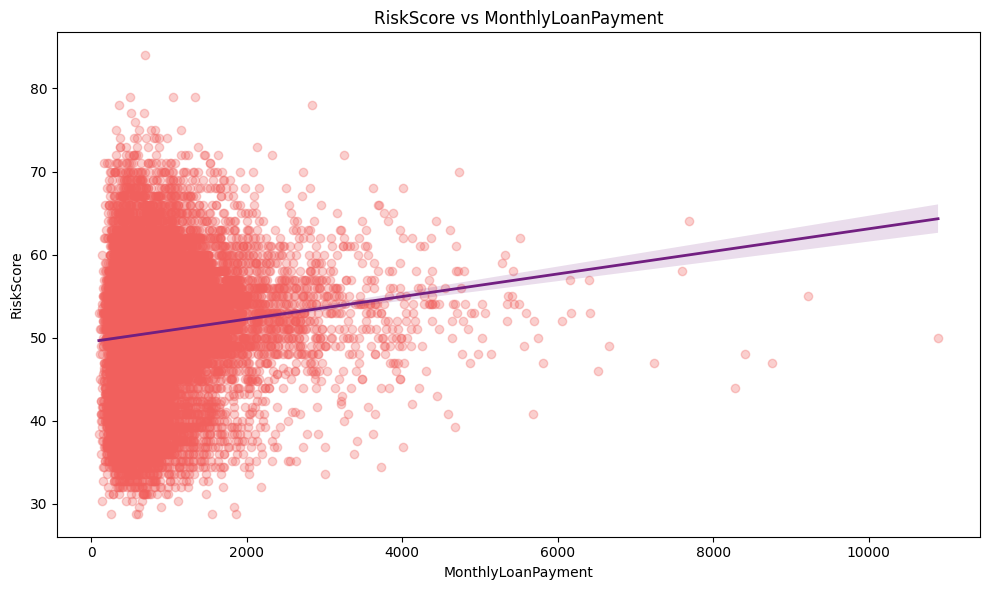

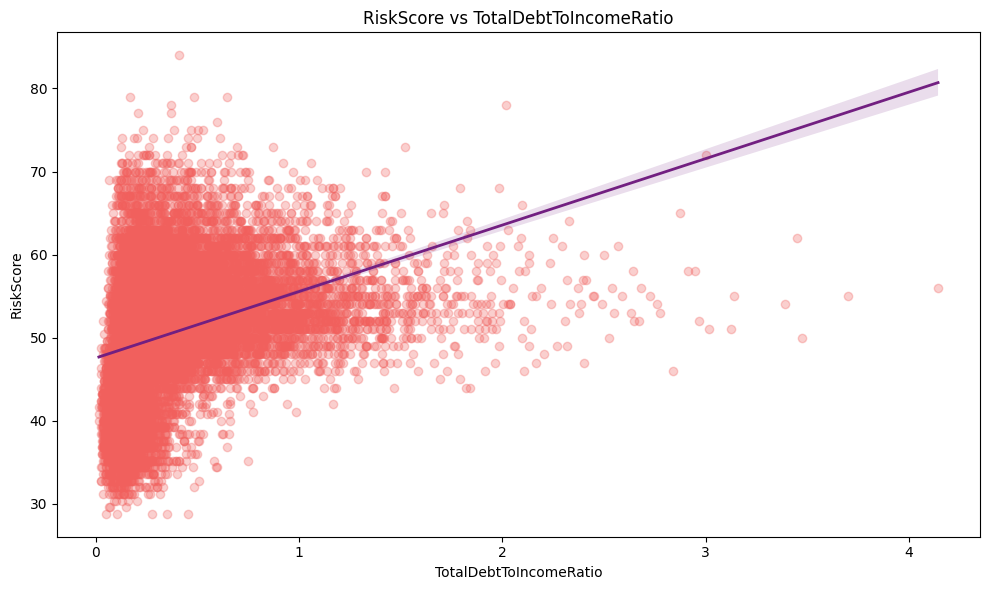

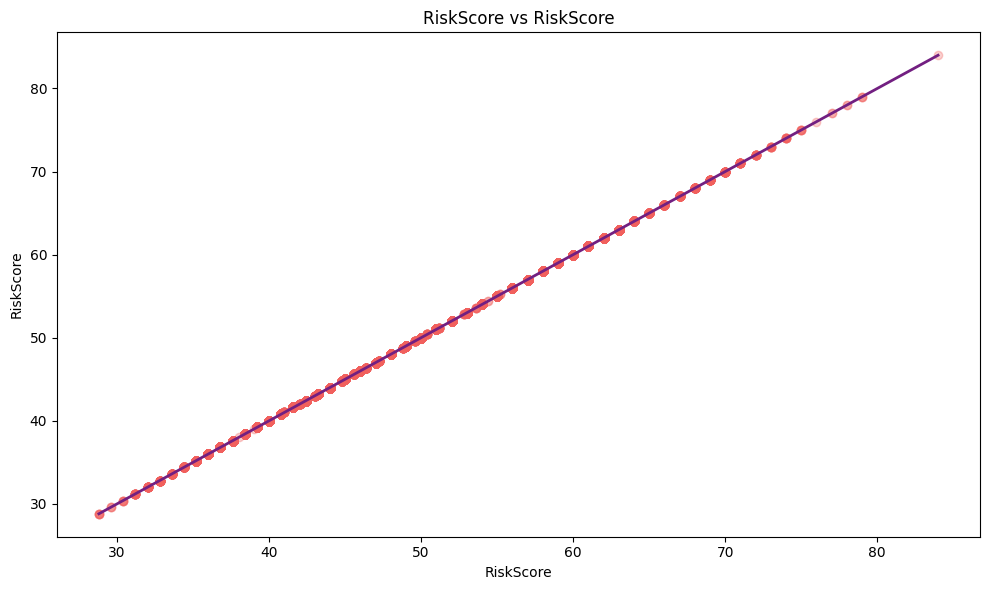

In [67]:
for col in numerical_features:
    colors = sns.color_palette("magma", 2)
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x=col,
        y=TARGET_VARIABLE,
        data=train_df,
        line_kws={"color": colors[0], "lw": 2},
        scatter_kws={"alpha": 0.3},
        color=colors[1],
    )
    plt.xlabel(col)
    plt.ylabel(TARGET_VARIABLE)
    plt.title(f"{TARGET_VARIABLE} vs {col}")
    plt.tight_layout()
    plt.show()

# 2 Preprocessing

## 2.2 Data Engineering

### 2.2.1 Missing Values

In [68]:
features_with_na = []

for col in data.columns:
    if data[col].isna().any():
        features_with_na.append(col)

print("Features with missing values:", features_with_na)

Features with missing values: []


### 2.2.2 Outliers

#### Numerical features

Age — outliers detected: 50.


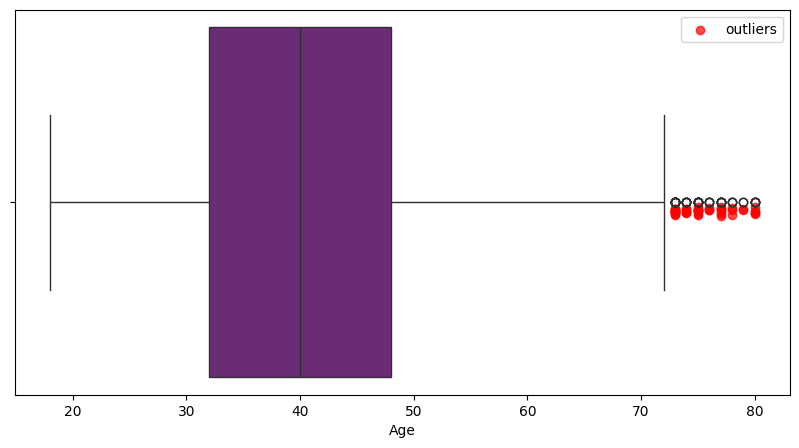

AnnualIncome — outliers detected: 769.


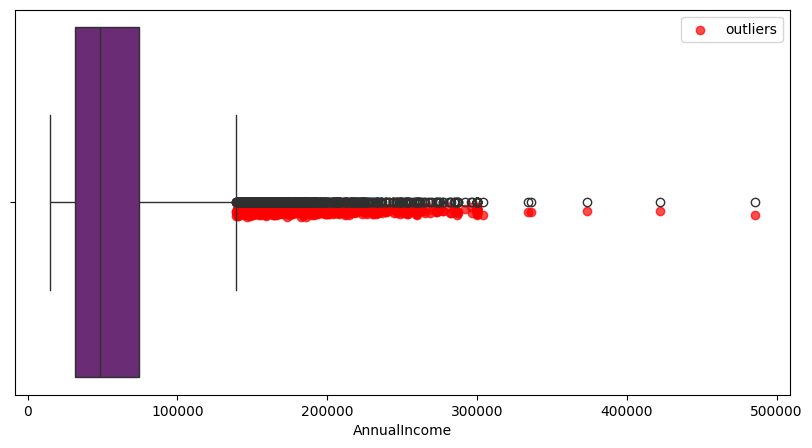

CreditScore — outliers detected: 201.


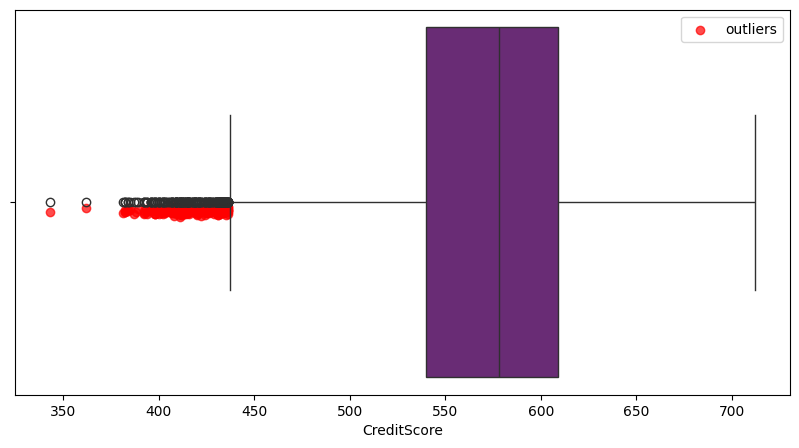

Experience — outliers detected: 53.


LoanAmount — outliers detected: 577.


LoanDuration — no outliers detected (IQR method).


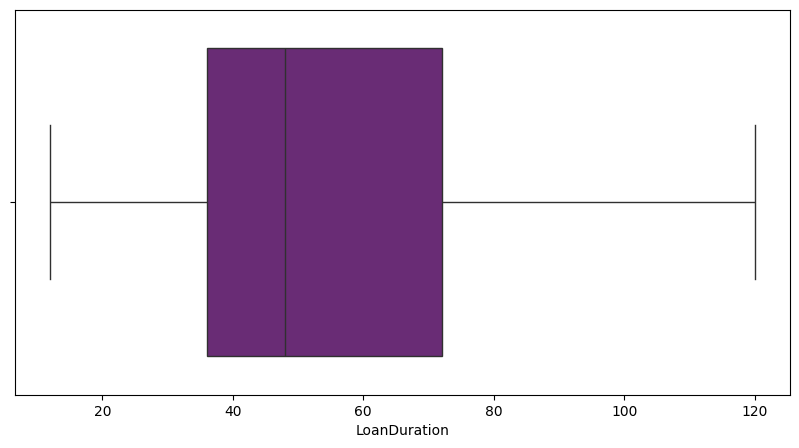

NumberOfDependents — no outliers detected (IQR method).


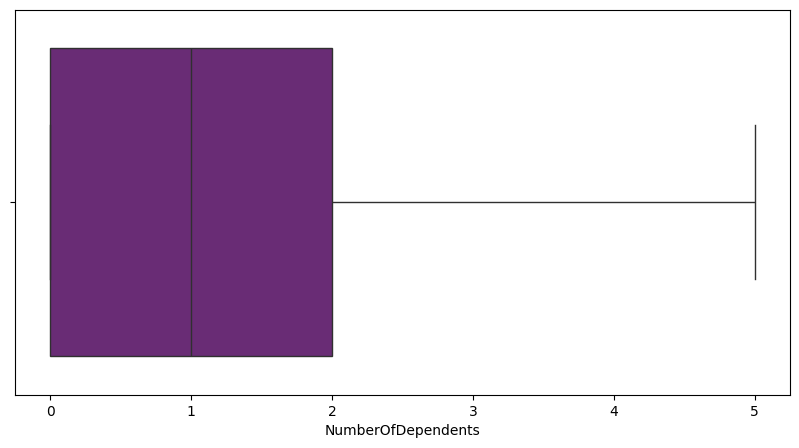

MonthlyDebtPayments — outliers detected: 588.


CreditCardUtilizationRate — outliers detected: 104.


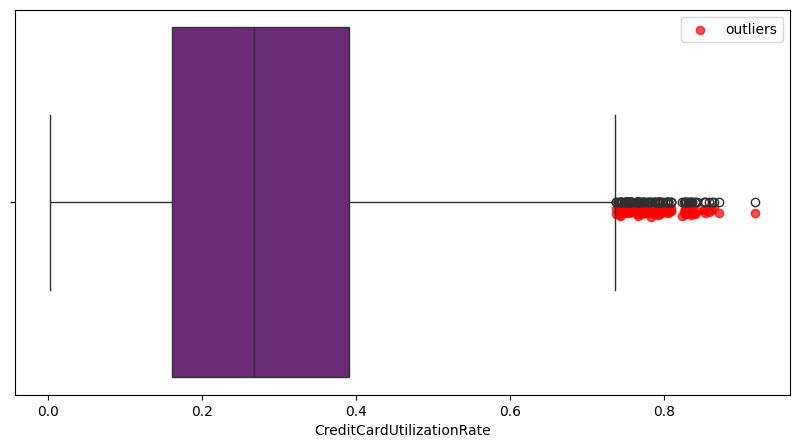

NumberOfOpenCreditLines — outliers detected: 197.


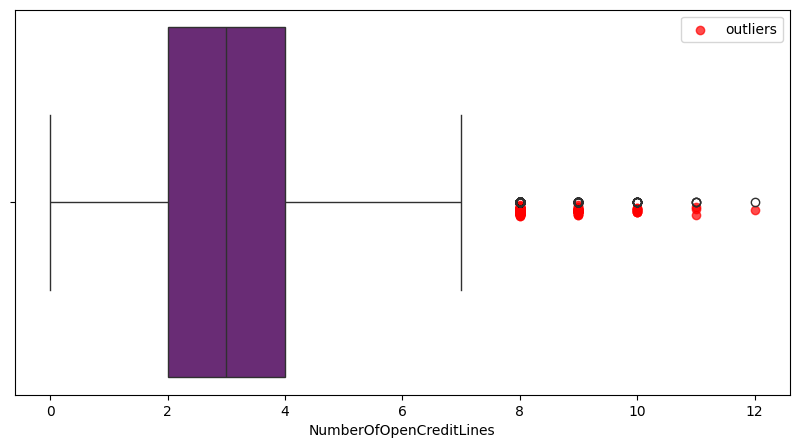

NumberOfCreditInquiries — outliers detected: 15.


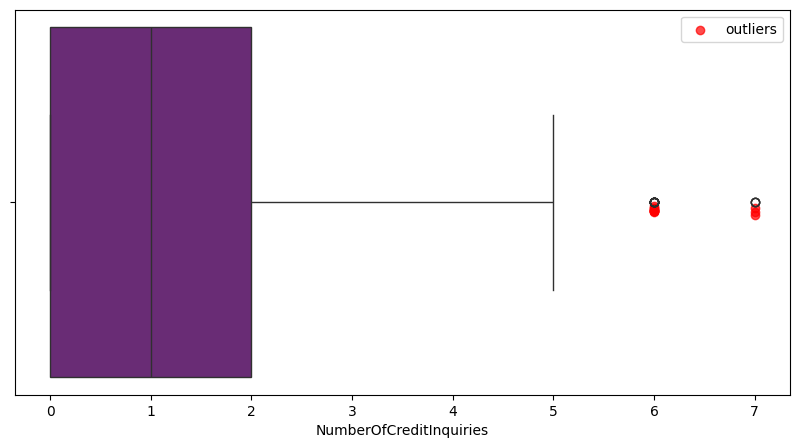

DebtToIncomeRatio — outliers detected: 115.


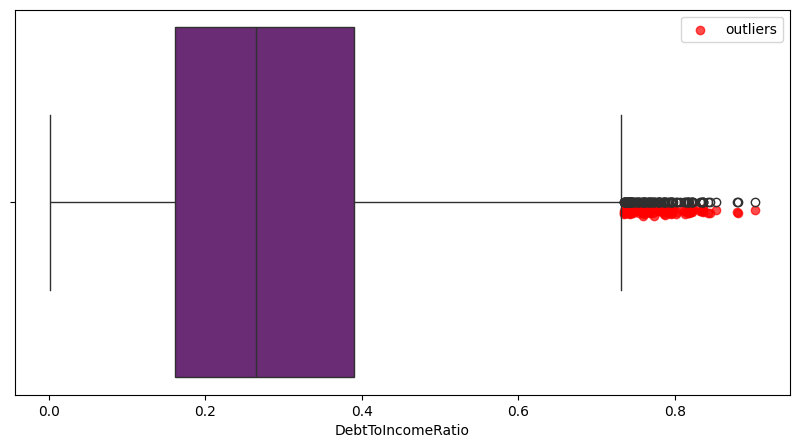

PaymentHistory — outliers detected: 193.


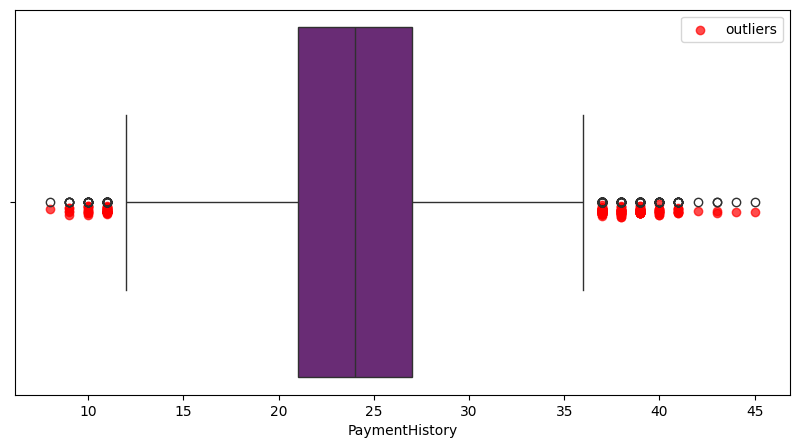

LengthOfCreditHistory — no outliers detected (IQR method).


SavingsAccountBalance — outliers detected: 1276.


CheckingAccountBalance — outliers detected: 1231.


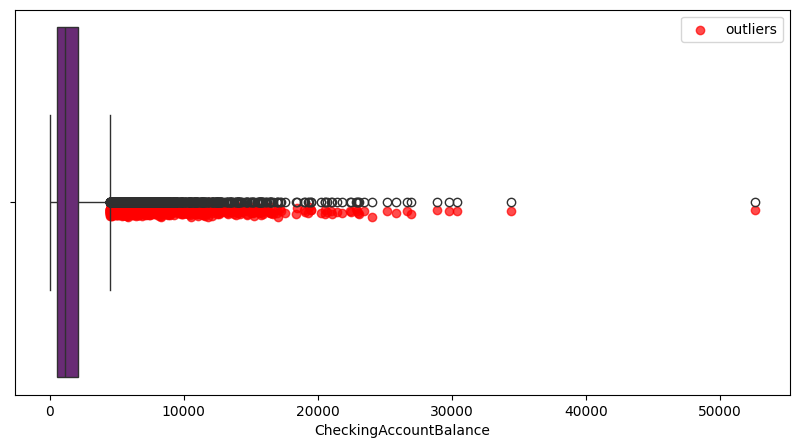

TotalAssets — outliers detected: 1120.


TotalLiabilities — outliers detected: 1220.


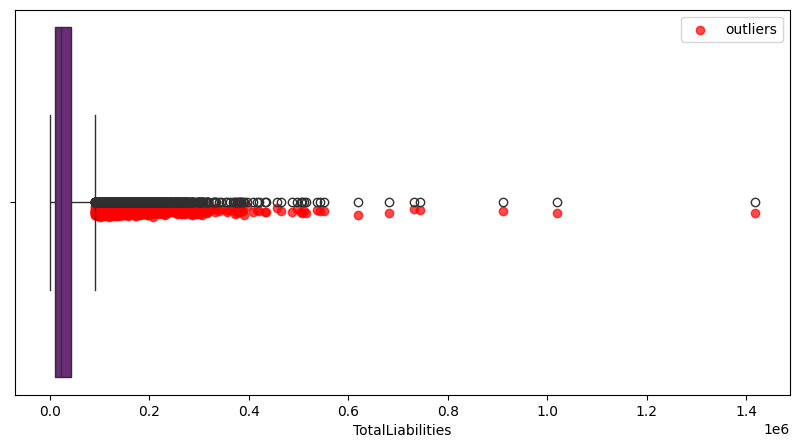

MonthlyIncome — outliers detected: 753.


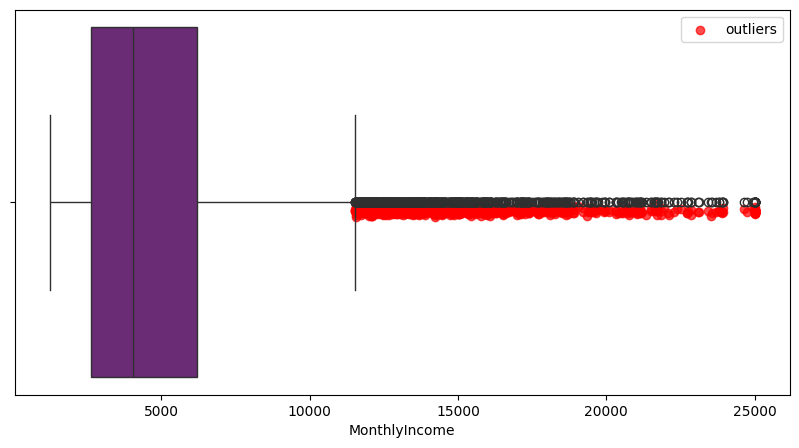

UtilityBillsPaymentHistory — outliers detected: 244.


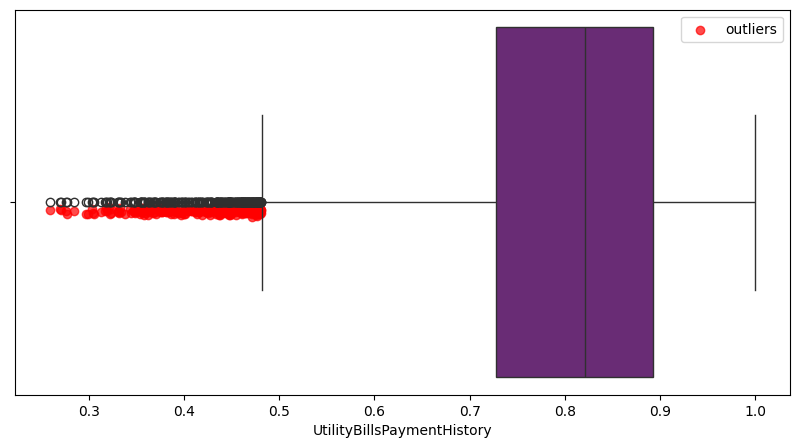

JobTenure — outliers detected: 193.


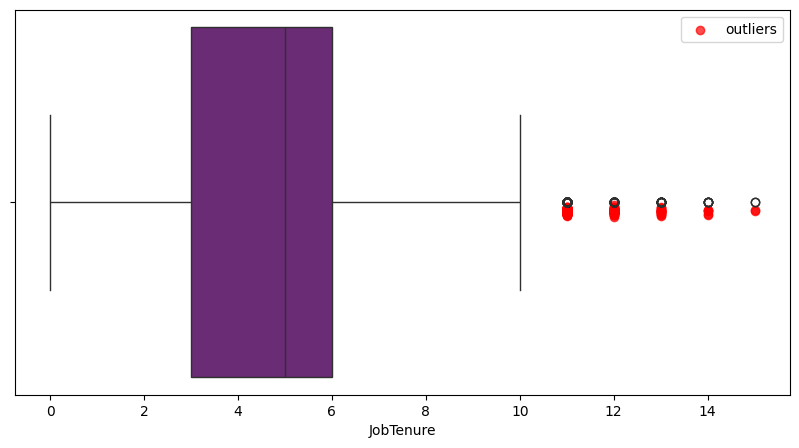

NetWorth — outliers detected: 1212.


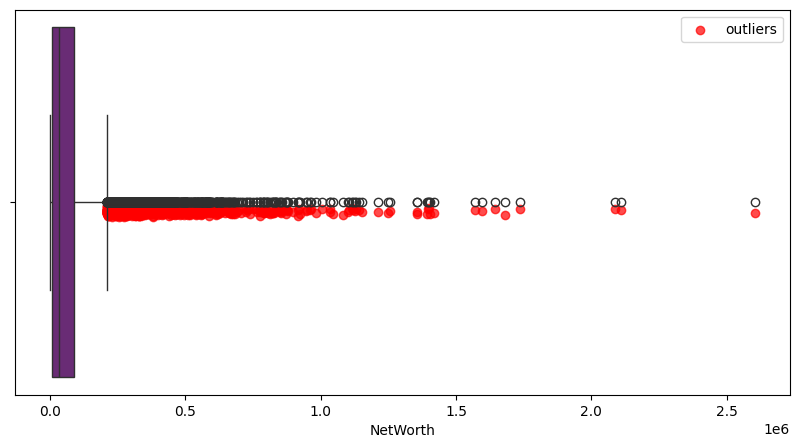

BaseInterestRate — outliers detected: 173.


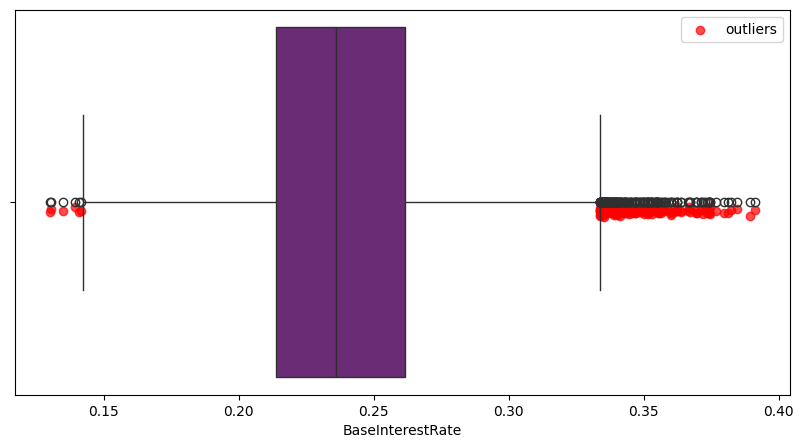

InterestRate — outliers detected: 177.


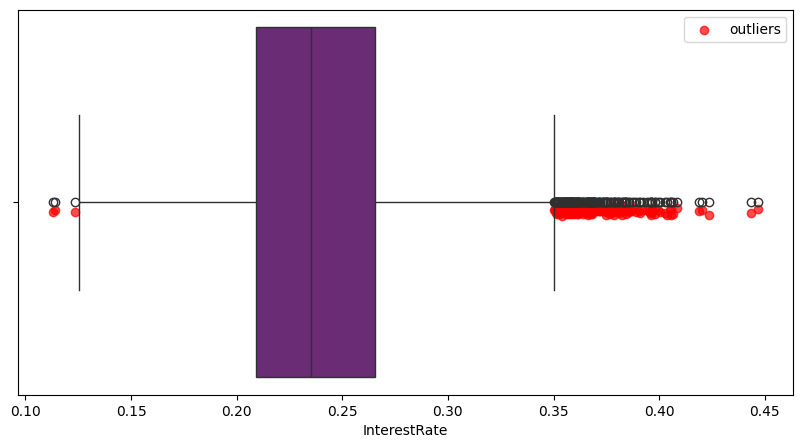

MonthlyLoanPayment — outliers detected: 858.


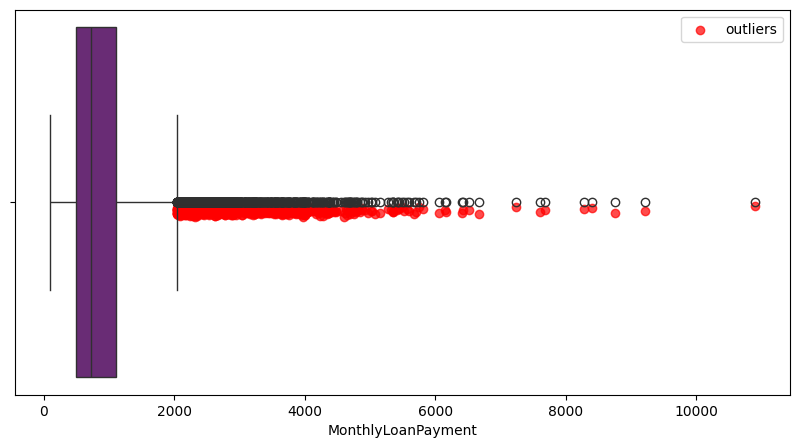

TotalDebtToIncomeRatio — outliers detected: 908.


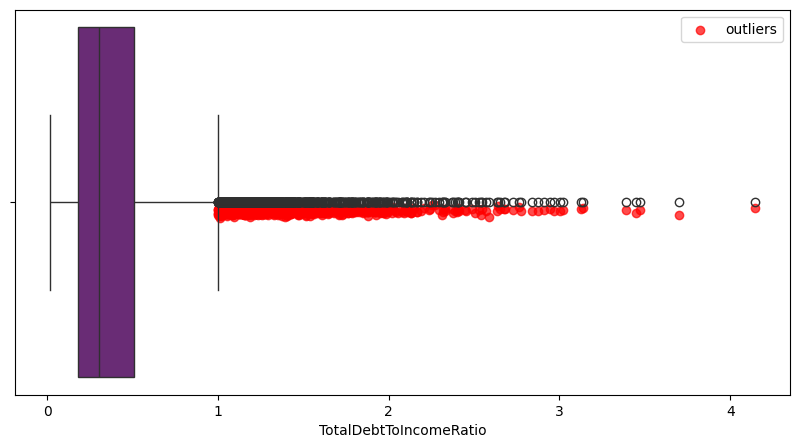

RiskScore — outliers detected: 60.


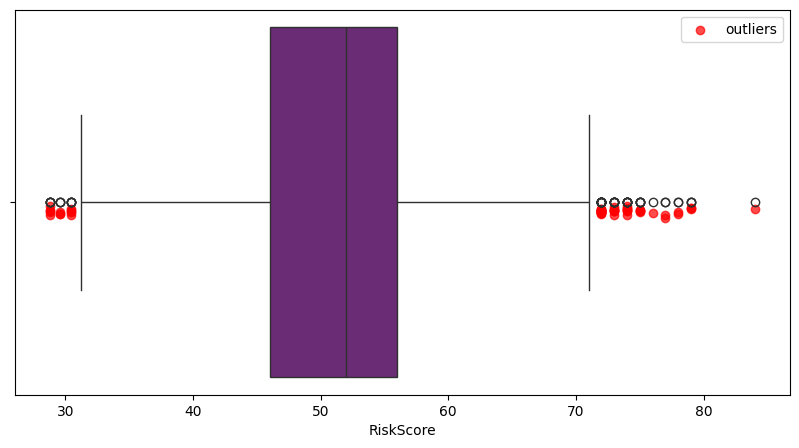

In [69]:
for col in numerical_features:
    colors = sns.color_palette("magma", 2)
    plt.figure(figsize=(10, 5))
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    sns.boxplot(x=train_df[col], color=colors[0])
    outliers = train_df[(train_df[col] < lower) | (train_df[col] > upper)][col]

    if not outliers.empty:
        y_jitter = np.random.normal(loc=0.02, scale=0.005, size=outliers.shape[0])
        plt.scatter(outliers.values, y_jitter, color="red", alpha=0.7, label="outliers")
        plt.legend()
        print(f"{col} — outliers detected: {len(outliers)}.")
    else:
        print(f"{col} — no outliers detected (IQR method).")
    plt.show()

#### Categorical features

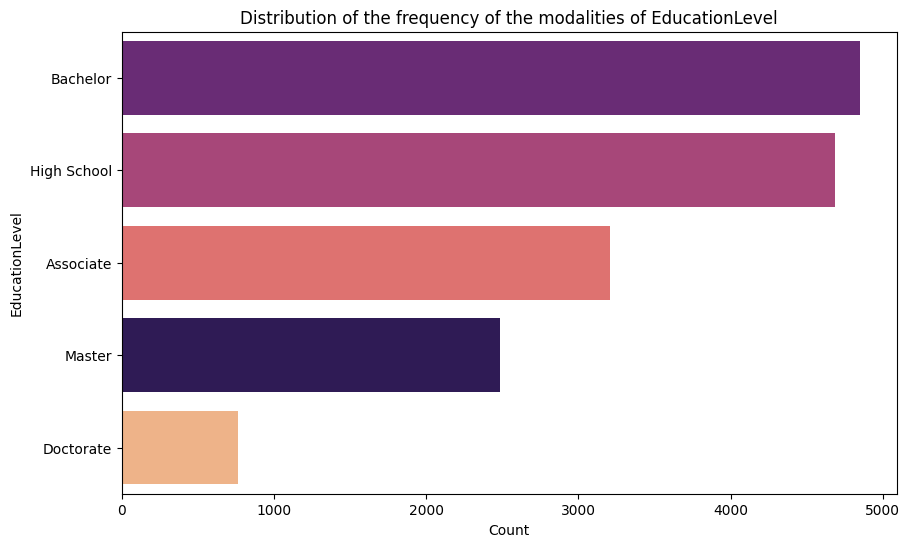

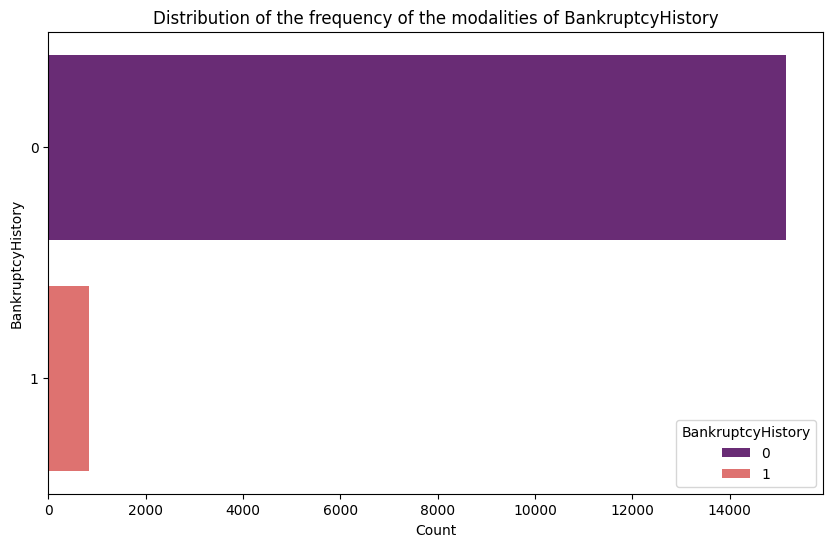

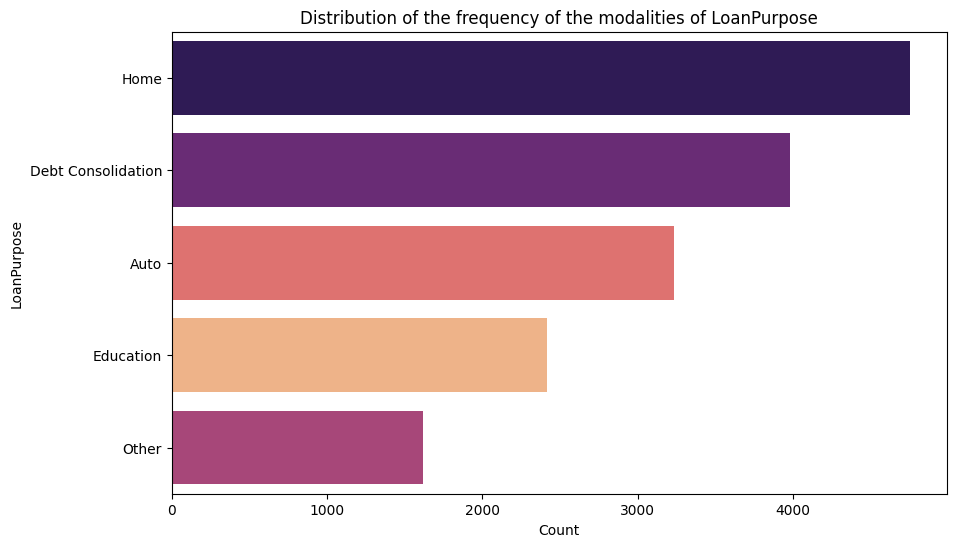

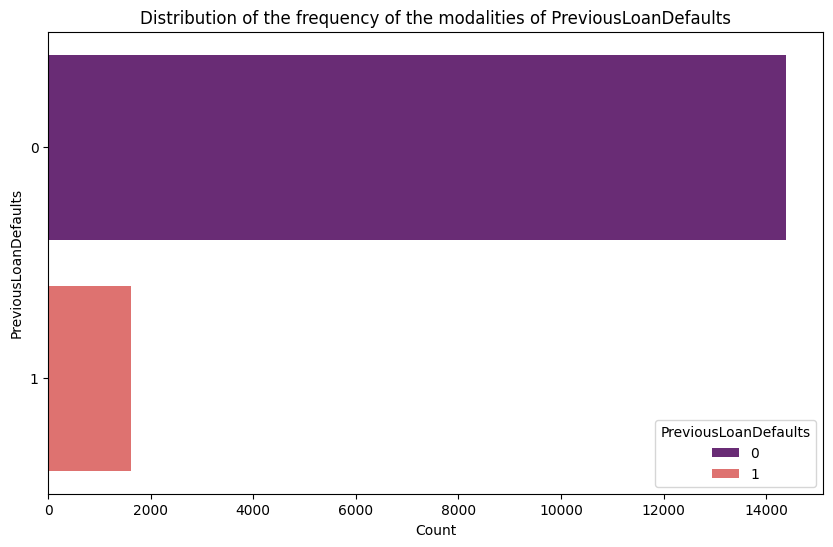

In [70]:
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(
        y=col,
        data=train_df,
        order=train_df[col].value_counts().index,
        palette="magma",
        hue=col,
    )
    plt.title("Distribution of the frequency of the modalities of " + col)
    plt.xlabel("Count")
    plt.show()

### 2.2.3 Data transformation - Automated Preprocessing Pipeline Construction

In [71]:
def create_full_pipeline(
    model: object,
    quantitative_features: list[str],
    categorical_features: list[str],
    use_scaling=True,
    use_encoding=True,
) -> Pipeline:
    """Create a full machine learning pipeline with preprocessing and model.

    Args:
        model: The estimator (model) to place at the end of the pipeline.
        quantitative_features (list): List of names of quantitative columns.
        categorical_features (list): List of names of categorical columns.
        use_scaling (bool): If True, apply StandardScaler to quantitative features.
        use_encoding (bool): If True, apply OneHotEncoder to categorical features.

    Returns:
        sklearn.pipeline.Pipeline: The complete pipeline.

    """
    transformers = []
    if quantitative_features:
        num_transformer = StandardScaler() if use_scaling else "passthrough"
        transformers.append(("num", num_transformer, quantitative_features))

    if categorical_features:
        cat_transformer = (
            OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            if use_encoding
            else "passthrough"
        )
        transformers.append(("cat", cat_transformer, categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")

    return Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

## 2.3 Feature Engineering

In [72]:
def create_new_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create new features based on financial and demographic ratios.

    Args:
        df (pd.DataFrame): the input DataFrame.

    Returns:
        pd.DataFrame: the DataFrame with the new features created.

    """
    df_new = df.copy()

    # Category 1. Repayment Capacity Ratios
    df_new["TotalMonthlyPayments"] = (
        df_new["MonthlyDebtPayments"] + df_new["MonthlyLoanPayment"]
    )
    df_new["DTI_AfterLoan"] = (
        df_new["MonthlyDebtPayments"] + df_new["MonthlyLoanPayment"]
    ) / (df_new["MonthlyIncome"] + 1e-6)
    df_new["Disposable_Income"] = (
        df_new["MonthlyIncome"] - df_new["MonthlyDebtPayments"]
    )
    df_new["Safety_Cushion"] = (
        df_new["MonthlyIncome"]
        - df_new["MonthlyDebtPayments"]
        - df_new["MonthlyLoanPayment"]
    )

    # Category 2. Wealth and Leverage Ratios
    df_new["Leverage_Ratio"] = df_new["TotalLiabilities"] / (
        df_new["TotalAssets"] + 1e-6
    )
    df_new["Savings_to_Loan_Ratio"] = df_new["SavingsAccountBalance"] / (
        df_new["LoanAmount"] + 1e-6
    )
    df_new["Savings_to_Payment_Ratio"] = df_new["SavingsAccountBalance"] / (
        df_new["MonthlyLoanPayment"] + 1e-6
    )
    df_new["Liquid_Assets"] = (
        df_new["SavingsAccountBalance"] + df_new["CheckingAccountBalance"]
    )

    # Category 3. Credit Behavior Ratios
    df_new["Inquiries_per_History_Year"] = df_new["NumberOfCreditInquiries"] / (
        df_new["LengthOfCreditHistory"] + 1e-6
    )
    df_new["Debt_per_Credit_Line"] = df_new["TotalLiabilities"] / (
        df_new["NumberOfOpenCreditLines"] + 1e-6
    )
    df_new["InterestRate_Spread"] = df_new["InterestRate"] - df_new["BaseInterestRate"]

    # Category 4. Demographic and Stability Ratios
    df_new["Income_per_Dependent"] = df_new["MonthlyIncome"] / (
        df_new["NumberOfDependents"] + 1e-6
    )
    df_new["Experience_vs_JobTenure_Ratio"] = df_new["JobTenure"] / (
        df_new["Experience"] + 1e-6
    )
    return df_new

# 4 Model evaluation

## 4.1 Standardized Hyperparameter Optimization Strategy

In [73]:
def create_grid_search(
    estimator: object,
    param_grid: dict,
    num_splits: int,
) -> GridSearchCV:
    """Create a GridSearchCV object for hyperparameter optimization.

    Args:
        estimator: The estimator to optimize.
        param_grid: The parameters to test.
        num_splits: The number of splits for cross-validation.

    Returns:
        GridSearchCV: The configured GridSearchCV object.

    """
    return GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=KFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_SEED),
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )

In [74]:
X_train = create_new_features(X_train)
X_test = create_new_features(X_test)

numerical_features, categorical_features = create_feature_arrays(X_train)

variables_categorielles_full = categorical_features.copy()
variables_numeriques_full = numerical_features.copy()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(
    f"Categorical features ({len(categorical_features)}): {categorical_features}",
)

Numerical features (39): ['Age', 'AnnualIncome', 'CreditScore', 'Experience', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'TotalMonthlyPayments', 'DTI_AfterLoan', 'Disposable_Income', 'Safety_Cushion', 'Leverage_Ratio', 'Savings_to_Loan_Ratio', 'Savings_to_Payment_Ratio', 'Liquid_Assets', 'Inquiries_per_History_Year', 'Debt_per_Credit_Line', 'InterestRate_Spread', 'Income_per_Dependent', 'Experience_vs_JobTenure_Ratio']
Categorical features (7): ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDe

## 4.2 Tested models

### 4.2.1 Dummy Regressor

In [75]:
dummy_model = DummyRegressor()
pipeline_dummy = create_full_pipeline(
    dummy_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=True,
    use_encoding=True,
)

num_splits = 5
param_grid_dummy = {
    "model__strategy": ["mean", "median", "quantile"],
    "model__quantile": [0, 0.25, 0.5, 0.75, 1],
}

grid_search_dummy = create_grid_search(
    estimator=pipeline_dummy,
    param_grid=param_grid_dummy,
    num_splits=num_splits,
)

grid_search_dummy.fit(X_train, y_train)

print(f"Best parameters (Dummy): {grid_search_dummy.best_params_}")
print(f"Best score (Dummy - neg_mse): {grid_search_dummy.best_score_}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters (Dummy): {'model__quantile': 0, 'model__strategy': 'mean'}
Best score (Dummy - neg_mse): -60.56286193779296


### 4.2.2 Lasso and Ridge Regressors

In [76]:
lasso_model = Lasso(random_state=RANDOM_SEED, max_iter=10000)
pipeline_lasso = create_full_pipeline(
    lasso_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=True,
    use_encoding=True,
)

num_splits = 5
param_grid_lasso = {"model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search_lasso = create_grid_search(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    num_splits=num_splits,
)

grid_search_lasso.fit(X_train, y_train)

print(f"Best parameters (Lasso): {grid_search_lasso.best_params_}")
print(f"Best score (Lasso - neg_mse): {grid_search_lasso.best_score_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.494e+02, tolerance: 7.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.491e+02, tolerance: 7.739e+01
  model = cd_fast.enet_coordinate_descent(
/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Best parameters (Lasso): {'model__alpha': 0.001}
Best score (Lasso - neg_mse): -12.842045848961448


/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.214e+02, tolerance: 9.689e+01
  model = cd_fast.enet_coordinate_descent(


In [77]:
ridge_model = Ridge(random_state=RANDOM_SEED)
pipeline_ridge = create_full_pipeline(
    ridge_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=True,
    use_encoding=True,
)

num_splits = 5
param_grid_ridge = {"model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search_ridge = create_grid_search(
    estimator=pipeline_ridge,
    param_grid=param_grid_ridge,
    num_splits=num_splits,
)

grid_search_ridge.fit(X_train, y_train)

print(f"Best parameters (Ridge): {grid_search_ridge.best_params_}")
print(f"Best score (Ridge - neg_mse): {grid_search_ridge.best_score_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters (Ridge): {'model__alpha': 10.0}
Best score (Ridge - neg_mse): -12.843983585719041


### 4.2.3 Decision Tree and Random Forest Regressor

In [78]:
decisionTree_model = DecisionTreeRegressor(random_state=RANDOM_SEED)
pipeline_decisionTree = create_full_pipeline(
    decisionTree_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=False,
    use_encoding=True,
)

num_splits = 5
param_grid_decisionTree = {
    "model__max_depth": [None, 1, 2, 3],
    "model__min_samples_split": [55, 57, 60, 62, 65, 67, 70, 73, 75],
}

grid_search_decisionTree = create_grid_search(
    estimator=pipeline_decisionTree,
    param_grid=param_grid_decisionTree,
    num_splits=num_splits,
)

grid_search_decisionTree.fit(X_train, y_train)

print(f"Best parameters (Decision Tree): {grid_search_decisionTree.best_params_}")
print(
    f"Best score (Decision Tree - neg_mse): {grid_search_decisionTree.best_score_}",
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters (Decision Tree): {'model__max_depth': None, 'model__min_samples_split': 57}
Best score (Decision Tree - neg_mse): -13.524510039148666


In [79]:
randomForest_model = RandomForestRegressor(random_state=RANDOM_SEED)
pipeline_randomForest = create_full_pipeline(
    randomForest_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=False,
    use_encoding=True,
)

num_splits = 5
param_grid_randomForest = {
    "model__n_estimators": [200],
    "model__max_depth": [10, 20, None],
    "model__min_samples_leaf": [1, 2, 4],
}

grid_search_randomForest = create_grid_search(
    estimator=pipeline_randomForest,
    param_grid=param_grid_randomForest,
    num_splits=num_splits,
)

grid_search_randomForest.fit(X_train, y_train)

print(f"Best parameters (Random Forest): {grid_search_randomForest.best_params_}")
print(
    f"Best score (Random Forest - neg_mse): {grid_search_randomForest.best_score_}",
)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters (Random Forest): {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
Best score (Random Forest - neg_mse): -7.539110343805144


### 4.2.4 Gradient Boosting, XGBoost and CatBoost

In [80]:
GB_model = GradientBoostingRegressor(random_state=RANDOM_SEED)
pipeline_GB = create_full_pipeline(
    GB_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=False,
    use_encoding=True,
)

num_splits = 5
param_grid_GB = {
    "model__n_estimators": [50, 100, 200, 250],
    "model__learning_rate": [0.3, 0.5, 0.7, 0.9],
}

grid_search_GB = create_grid_search(
    estimator=pipeline_GB,
    param_grid=param_grid_GB,
    num_splits=num_splits,
)

grid_search_GB.fit(X_train, y_train)

print(f"Best parameters (GB): {grid_search_GB.best_params_}")
print(f"Best score (GB - neg_mse): {grid_search_GB.best_score_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters (GB): {'model__learning_rate': 0.3, 'model__n_estimators': 200}
Best score (GB - neg_mse): -6.021638339325941


In [81]:
XGBoost = xgb.XGBRegressor(random_state=RANDOM_SEED)
pipeline_XGBoost = create_full_pipeline(
    XGBoost,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=False,
    use_encoding=True,
)

num_splits = 5
param_grid_XGBoost = {
    "model__n_estimators": [100, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
}

grid_search_XGBoost = create_grid_search(
    estimator=pipeline_XGBoost,
    param_grid=param_grid_XGBoost,
    num_splits=num_splits,
)

grid_search_XGBoost.fit(X_train, y_train)

print(f"Best parameters (XGBoost): {grid_search_XGBoost.best_params_}")
print(f"Best score (XGBoost - neg_mse): {grid_search_XGBoost.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters (XGBoost): {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__subsample': 0.8}
Best score (XGBoost - neg_mse): -5.2771208982610265


In [92]:
catBoost_model = CatBoostRegressor(
    random_state=RANDOM_SEED,
    verbose=0,
    cat_features=variables_categorielles_full,
)

num_splits = 5
param_grid_catBoost = {
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8],
    "iterations": [500, 1000],
    "l2_leaf_reg": [1, 3, 5],
}

grid_search_catBoost = create_grid_search(
    estimator=catBoost_model,
    param_grid=param_grid_catBoost,
    num_splits=num_splits,
)

grid_search_catBoost.fit(X_train, y_train)

print(f"Best parameters (CatBoost): {grid_search_catBoost.best_params_}")
print(f"Best score (CatBoost - neg_mse): {grid_search_catBoost.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters (CatBoost): {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Best score (CatBoost - neg_mse): -4.950111082818124


### 4.2.5 Neural Network

In [84]:
mlp_model = MLPRegressor(
    random_state=RANDOM_SEED,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    activation="relu",
)
pipeline_mlp = create_full_pipeline(
    mlp_model,
    variables_numeriques_full,
    variables_categorielles_full,
    use_scaling=True,
    use_encoding=True,
)

num_splits = 5
param_grid_mlp = {
    "model__hidden_layer_sizes": [
        (50,),
        (100,),
        (50, 20),
        (100, 50),
    ],
    "model__alpha": [0.0001, 0.001, 0.01],
    "model__learning_rate_init": [0.001, 0.01],
    "model__max_iter": [1000],
}

grid_search_mlp = create_grid_search(
    estimator=pipeline_mlp,
    param_grid=param_grid_mlp,
    num_splits=num_splits,
)

grid_search_mlp.fit(X_train, y_train)

print(f"Best parameters (MLP): {grid_search_mlp.best_params_}")
print(f"Best score (MLP - neg_mse): {grid_search_mlp.best_score_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters (MLP): {'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.01, 'model__max_iter': 1000}
Best score (MLP - neg_mse): -4.584642300233666


## 4.3 Performance comparison

In [93]:
models = {
    "Dummy Regressor": grid_search_dummy,
    "Lasso Regression": grid_search_lasso,
    "Ridge Regression": grid_search_ridge,
    "Decision Tree": grid_search_decisionTree,
    "Random Forest": grid_search_randomForest,
    "Gradient Boosting": grid_search_GB,
    "XGBoost": grid_search_XGBoost,
    "CatBoost": grid_search_catBoost,
    "Neural Network": grid_search_mlp,
}

In [94]:
rows = []
for name, model in models.items():
    best_params = model.best_params_
    best_neg_mse = model.best_score_
    rmse = np.sqrt(-best_neg_mse)
    rows.append(
        {
            "Model": name,
            "Best Params": best_params,
            "MSE": -best_neg_mse,
            "RMSE": rmse,
        },
    )

summary_df = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
summary_df

Best Params  \
Model                                                                  
Neural Network     {'model__alpha': 0.001, 'model__hidden_layer_s...   
CatBoost           {'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...   
XGBoost            {'model__learning_rate': 0.05, 'model__max_dep...   
Gradient Boosting  {'model__learning_rate': 0.3, 'model__n_estima...   
Random Forest      {'model__max_depth': 20, 'model__min_samples_l...   
Lasso Regression                             {'model__alpha': 0.001}   
Ridge Regression                              {'model__alpha': 10.0}   
Decision Tree      {'model__max_depth': None, 'model__min_samples...   
Dummy Regressor    {'model__quantile': 0, 'model__strategy': 'mean'}   

                         MSE      RMSE  
Model                                   
Neural Network      4.584642  2.141178  
CatBoost            4.950111  2.224885  
XGBoost             5.277121  2.297198  
Gradient Boosting   6.021638  2.453903  
Random Forest       7.539110  2.745744  
Lasso Regression   12.842046  3.583580  
Ridge Regression   12.843984  3.583850  
Decision Tree      13.524510  3.677568  
Dummy Regressor    60.562862  7.782214

In [95]:
rows = []
for name, model in models.items():
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rows.append(
        {
            "Model": name,
            "Params": model.best_params_,
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
        },
    )

predictions_df = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
predictions_df

Params  \
Model                                                                  
Neural Network     {'model__alpha': 0.001, 'model__hidden_layer_s...   
CatBoost           {'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...   
XGBoost            {'model__learning_rate': 0.05, 'model__max_dep...   
Gradient Boosting  {'model__learning_rate': 0.3, 'model__n_estima...   
Random Forest      {'model__max_depth': 20, 'model__min_samples_l...   
Lasso Regression                             {'model__alpha': 0.001}   
Ridge Regression                              {'model__alpha': 10.0}   
Decision Tree      {'model__max_depth': None, 'model__min_samples...   
Dummy Regressor    {'model__quantile': 0, 'model__strategy': 'mean'}   

                         MSE       MAE      RMSE        R2  
Model                                                       
Neural Network      4.736872  1.484767  2.176436  0.921385  
CatBoost            4.971970  1.444237  2.229792  0.917483  
XGBoost             5.376472  1.480055  2.318722  0.910770  
Gradient Boosting   5.876054  1.652423  2.424057  0.902479  
Random Forest       7.632536  1.677884  2.762704  0.873328  
Lasso Regression   12.980593  2.796357  3.602859  0.784570  
Ridge Regression   12.981286  2.795650  3.602955  0.784558  
Decision Tree      13.545178  2.264977  3.680377  0.775199  
Dummy Regressor    60.256905  6.109831  7.762532 -0.000045

In [96]:
best_model = grid_search_mlp.best_estimator_
best_params = grid_search_mlp.best_params_

preprocessor = best_model.named_steps["preprocessor"]
nn_model = best_model.named_steps["model"]

print(f"The best model is the MLP with the following parameters: {best_params}")
print(f"Preprocessor: {preprocessor}")
print(f"Model: {nn_model}")

The best model is the MLP with the following parameters: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.01, 'model__max_iter': 1000}
Preprocessor: ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Age', 'AnnualIncome', 'CreditScore',
                                  'Experience', 'LoanAmount', 'LoanDuration',
                                  'NumberOfDependents', 'MonthlyDebtPayments',
                                  'CreditCardUtilizationRate',
                                  'NumberOfOpenCreditLines',
                                  'NumberOfCreditInquiries',
                                  'DebtToIncomeRatio', 'PaymentHistory',
                                  'LengthOfCreditHistory',
                                  'SavingsA...
                                  'NetWorth', 'BaseInterestRate',
                                  'InterestRate',

In [97]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

## 4.5 Variable impact

In [98]:
explainer = shap.KernelExplainer(
    nn_model.predict,
    shap.sample(X_train_processed_df, 100),
)

sample_size = 500
if len(X_test) > sample_size:
    X_test_sample = shap.sample(X_test_processed_df, sample_size)
else:
    X_test_sample = X_test_processed_df

shap_values = explainer.shap_values(X_test_sample)

100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


In [99]:
plt.figure()
shap.summary_plot(
    shap_values,
    X_test_sample,
    plot_type="bar",
    show=False,
    plot_size=(10, 6),
)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

plt.figure()
shap.summary_plot(shap_values, X_test_sample, show=False, plot_size=(10, 6))
plt.title("Detailed Feature Importance (SHAP)")
plt.tight_layout()
plt.show()